# Stratospheric and Tropospheric Flux Contributions to the Polar Cap Energy Budgets

This notebook includes the python code used for the figures and tables in Cardinale et al. (2021).

https://doi.org/10.1175/jcli-d-20-0722.1

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sp
import scipy.integrate as integ
from scipy import signal
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Data and Functions

See ***Cardinale_Data_Download.ipynb*** for instructions on MERRA-2 data download and energy flux calculations.

All functions are designed to work with xarray.

In [2]:
data_loc = 'condensed_data/'

In [3]:
#polar cap-averaged outgoing longwave radiation
OLR = xr.open_dataset(data_loc + 'MERRA2_OLR_NH_1980_2016.nc')
#polar cap-averaged surface absorbed and emitted longwave radiation
SLR = xr.open_dataset(data_loc + 'MERRA2_SLR_NH_1980_2016.nc')
#polar cap-averaged surface net downward shortwave radiation
DSW = xr.open_dataset(data_loc + 'MERRA2_DSW_NH_1980_2016.nc')
#polar cap-averaged surface latent and sensible heat fluxes from turbulence 
SHLH = xr.open_dataset(data_loc + 'MERRA2_SHLHFLX_NH_1980_2016.nc')
#polar cap-averaged moist enthalpy (latent and sensible heat) and moist enthalpy tendency
merra_VT = xr.open_dataset(data_loc + 'MERRA2_VT_NH_1980_2016.nc')
#MSE flux at 70N
merra_ET = xr.open_dataset(data_loc + 'MERRA2_ET_NH_1980_2016.nc')
#MSE flux at 65S
merra_ET2 = xr.open_dataset(data_loc + 'MERRA2_ET_SH_1980_2016.nc')
#mass weighted vertically averaged meridional wind at 70N
merra_V = xr.open_dataset(data_loc + 'merra2_v_vertical_mean_nh.nc')
#polar cap-averged surface pressure at 70N
merra_PS = xr.open_dataset(data_loc + 'merra2_PS_pc_mean_nh.nc')

In [4]:
data = pd.read_csv(data_loc + 'ssw.txt',delimiter=',')
#zonal wind at 60N and 10 hPa
u_10mb = xr.DataArray(np.squeeze(np.array(data)),coords=[pd.date_range('1980-01-01','2016-12-31',freq='D')],dims=['time'])

In [5]:
#circumference at 70N and area poleward of 70N
c = 40075000. * np.cos(np.deg2rad(70.))
a = (2.*6371000.**2*np.pi)*(np.sin(np.deg2rad(90.))-np.sin(np.deg2rad(70.))) 
#circumference at 65S and area poleward of 65S
c2 = 40075000. * np.cos(np.deg2rad(-65.))
a2 = -(2.*6371000.**2*np.pi)*(np.sin(np.deg2rad(-90.))-np.sin(np.deg2rad(-65.))) 
#seconds in a day
sid = 86400.
g = 9.81
Lv = 2.5e6
Cp = 1004.

In [6]:
#70N
LH_H = merra_ET.LH ; SH_H = merra_ET.SH; GP_H = merra_ET.GP
DSE_H = SH_H+GP_H ; MSE_H = LH_H+SH_H+GP_H

In [7]:
#65S
LH_H2 = merra_ET2.LH ; SH_H2 = merra_ET2.SH ; GP_H2 = merra_ET2.GP
DSE_H2 = SH_H2+GP_H2 ; MSE_H2 = LH_H2+SH_H2+GP_H2

In [8]:
#outgoing longwave radiation
OLR = OLR.OLR_PC
#downward longwave radiation
DLR = SLR.SALR_PC
#upward longwave radiation
ULR = -SLR.SELR_PC
#downward shortwave radiation
DSW = DSW.NDSW_PC
#surface fluxes from turbulence (positive downward)
SHLH = -(SHLH.SHFLX_PC+SHLH.LHFLX_PC)
#moist enthalpy tendency
DMENTDT = merra_VT.DMENTDT

In [9]:
def h(circ=c,area=a):
    """conversion factor:
    energy flux to local MSE flux convergence (W/m2/100 hPa)"""
    return (circ/(area*g))*10**4

In [10]:
def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True))
            * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)

def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))

def pearson_correlation(x, y, dim):
    """pearson correlation function for use with xarray DataArrays"""
    return xr.apply_ufunc(
        pearson_correlation_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='allowed',
        output_dtypes=[float])

In [11]:
def integrate(array):
    """Computes the total vertical integral (trapezoidal Rule)."""
    return (np.squeeze(integ.trapz(array,x=-(merra_ET.lev*10**2)/g,axis=-1)))
def integrate_trop(array):
    """Computes the vertical integral over the troposphere (1000-300 hPa)"""
    return (np.squeeze(integ.trapz(array[:,0:21],x=-(merra_ET.lev[0:21]*10**2)/g,axis=-1)))
def integrate_strat(array):
    """Computes the vertical integral over the stratosphere (300-0.1 hPa)"""
    return (np.squeeze(integ.trapz(array[:,20:42],x=-(merra_ET.lev[20:42]*10**2)/g,axis=-1)))

def curly_bracket(array):
    """Computes the total mass weighted vertical average."""
    return (((np.squeeze(np.trapz(array,x=-(merra_ET.lev*10**2)/g,axis=-1)))) 
            / ((100000. / g)))
def curly_bracket_trop(array):
    """Computes the tropospheric mass weighted vertical average."""
    return (((np.squeeze(np.trapz(array[:,0:21],x=-(merra_ET.lev[0:21]*10**2)/g,axis=-1))))/((70000. / g)))
def curly_bracket_strat(array):
    """Computes the stratospheric mass weighted vertical average."""
    return (((np.squeeze(np.trapz(array[:,20:42],x=-(merra_ET.lev[20:42]*10**2)/g,axis=-1))))/((30000. / g)))
def curly_bracket_tropl(array):
    """Computes the lower-tropospheric (1000-900 hPa) mass weighted vertical average."""
    return (((np.squeeze(np.trapz(array[:,0:5],x=-(merra_ET.lev[0:5]*10**2)/g,axis=-1))))/((10000. / g)))

In [12]:
def ufunc(array,function):
    """Use with non-xarray functions that exlcude lev"""
    return xr.apply_ufunc(
        function, array,
        input_core_dims=[['lev']],
        exclude_dims={'lev'},
        dask='allowed',
        output_dtypes=[float])
def ufunc2(array,function):
    """Use with non-xarray functions"""
    return xr.apply_ufunc(
        function, array,
        dask='allowed',
        output_dtypes=[float])

In [13]:
def anom_daily(array):
    """Computes daily anomalies for length array"""
    mean = array.groupby('time.dayofyear').mean('time')
    anom = array.groupby('time.dayofyear') - mean
    return anom

In [14]:
def ann_cycle_daily(array):
    """Computes the daily mean annual cycle
    Change 'days' for different length arrays"""
    days = pd.period_range('1980-01','2016-12-31', freq='D')
    leap_cycle = xr.concat([array.sel(time=days.dayofyear==day).mean('time')
              for day in range(1,367)],'time')
    nonleap_cycle = xr.concat([array.sel(time=days.dayofyear==day).mean('time')
              for day in range(1,366)],'time')
    return leap_cycle,nonleap_cycle

In [15]:
def monthly_weight(array):
    """Weight monthly arrays by the days in each month."""
    w_array = ((array * array.time.dt.daysinmonth) / array.time.dt.daysinmonth.mean('time'))
    return w_array                

In [16]:
def monthly(daily_array,lev=True):
    """Daily mean array to monthly mean array.
    lev=True for arrays with pressure levels"""
    days = pd.period_range('1980-01','2016-12-31', freq='D')
    time = pd.date_range('1980-01','2017-01', freq='M')
    if lev==True:
        lev = daily_array.lev
        monthly_array = xr.DataArray(xr.concat([((daily_array)
                                .sel(time=xr.ufuncs.logical_and(days.month==month,days.year==year))).mean('time') 
                                               for year in range(1980,2017) for month in range(1,13)],'time'),
                                 coords=[time,lev],dims=['time','lev'])
    elif lev==False:
        monthly_array = xr.DataArray(xr.concat([((daily_array)
                                .sel(time=xr.ufuncs.logical_and(days.month==month,days.year==year))).mean('time') 
                                               for year in range(1980,2017) for month in range(1,13)],'time'),
                                 coords=[time],dims=['time'])
    return monthly_array

In [17]:
def ann_cycle_monthly(array):
    """Computes the monthly mean annual cycle from daily arrays"""
    days = pd.period_range('1980-01','2016-12-31', freq='D')
    ann_cycle = xr.concat([((array).sel(time=days.month==month)).mean('time') 
            for month in range(1,13)],'time')
    return ann_cycle

def ann_cycle_monthly2(array):
    """Computes the monthly mean annual cycle from monthly arrays"""
    months = pd.period_range('1980-01','2016-12-31', freq='M')
    ann_cycle = xr.concat([((array).sel(time=months.month==month)).mean('time') 
            for month in range(1,13)],'time')
    return ann_cycle

def ann_cycle_monthly_std(array):
    """Computes the monthly annual cycle of standard deviation from daily arrays"""
    monthly_array = monthly(array,lev=False)
    months = pd.period_range('1980-01','2016-12-31', freq='M')
    ann_cycle = xr.concat([((monthly_array).sel(time=months.month==month)).std('time')
            for month in range(1,13)],'time')
    return ann_cycle

def ann_cycle_monthly_std2(array):
    """Computes the monthly annual cycle of standard deviation from monthly arrays"""
    months = pd.period_range('1980-01','2016-12-31', freq='M')
    ann_cycle = xr.concat([((array).sel(time=months.month==month)).std('time')
            for month in range(1,13)],'time')
    return ann_cycle

In [18]:
def anom_monthly(array,lev=True):
    """Computes monthly anomalies from daily mean data."""
    months = pd.period_range('1980-01','2016-12', freq='M')
    ann_cycle = ann_cycle_monthly(array)
    if lev==True:
        monthly_array = monthly(array,lev=True)
    elif lev==False:
        monthly_array = monthly(array,lev=False)
    return xr.concat([monthly_array.sel(time=months.year==year) - ann_cycle
                      for year in range(1980,2017)],'time').chunk({'time':12})

def anom_monthly2(array,lev=True):
    """Computes monthly anomalies from monthly mean data."""
    months = pd.period_range('1980-01','2016-12', freq='M')
    ann_cycle = ann_cycle_monthly2(array)
    return xr.concat([array.sel(time=months.year==year) - ann_cycle
                      for year in range(1980,2017)],'time').chunk({'time':12})

In [19]:
def detrend_gufunc(array):
    return signal.detrend(array,0)
def detrend(array):
    """Linearly detrend anomaly data"""
    return xr.apply_ufunc(
        detrend_gufunc, array,
        dask='allowed',
        output_dtypes=[float])

In [20]:
def low_filt(data,N=1,Wn=1/32,btype='low'):
    """Butterworth low-pass filter"""
    sos = signal.butter(N, Wn, btype, output='sos')
    filt = signal.sosfiltfilt(sos, data)
    return filt

In [21]:
def periodic(array):
    """Append the first value to the end of an array.
    Used in Figure 3."""
    return xr.concat([(array),(array).isel(time=0)],'time')

In [22]:
def composite(array,events):
    """Daily mean composite in the 30 days before and after events."""
    comp = xr.concat([xr.concat([array.sel(time=slice(events[x]-np.array(30, dtype='timedelta64[D]')
                        ,events[x]+np.array(30, dtype='timedelta64[D]')))[y]
        for x in range(len(events))],'time').mean('time') for y in range(61)],'day')  
    return comp

In [23]:
#months and days in each season
#used for 3 and 5-month seasonal averages
winter_nh_d = merra_ET.time.where(xr.ufuncs.logical_or(MSE_H.time.dt.month>10
                                         ,MSE_H.time.dt.month<4)).dropna('time')
winter_nh_m = merra_ET.time.where(xr.ufuncs.logical_or(monthly(MSE_H).time.dt.month>10
                                         ,monthly(MSE_H).time.dt.month<4)).dropna('time')
winter_sh = merra_ET2.time.where(xr.ufuncs.logical_and(MSE_H2.time.dt.month>4
                                         ,MSE_H2.time.dt.month<10)).dropna('time')

winter_nh_3m_d = merra_ET.time.where(xr.ufuncs.logical_or(MSE_H.time.dt.month>11
                                         ,MSE_H.time.dt.month<3)).dropna('time')
winter_nh_3m_m = merra_ET.time.where(xr.ufuncs.logical_or(monthly(MSE_H).time.dt.month>11
                                         ,monthly(MSE_H).time.dt.month<3)).dropna('time')
winter_sh_3m = merra_ET2.time.where(xr.ufuncs.logical_and(MSE_H2.time.dt.month>5
                                         ,MSE_H2.time.dt.month<9)).dropna('time')

summer_nh_d = merra_ET.time.where(xr.ufuncs.logical_and(MSE_H.time.dt.month>5
                                         ,MSE_H.time.dt.month<9)).dropna('time')
summer_nh_m = merra_ET.time.where(xr.ufuncs.logical_and(monthly(MSE_H).time.dt.month>5
                                         ,monthly(MSE_H).time.dt.month<9)).dropna('time')
summer_sh = merra_ET2.time.where(xr.ufuncs.logical_or(MSE_H2.time.dt.month>11
                                         ,MSE_H2.time.dt.month<3)).dropna('time')

spring_nh_d = merra_ET.time.where(xr.ufuncs.logical_and(MSE_H.time.dt.month>2
                                         ,MSE_H.time.dt.month<6)).dropna('time')
spring_nh_m = merra_ET.time.where(xr.ufuncs.logical_and(monthly(MSE_H).time.dt.month>2
                                         ,monthly(MSE_H).time.dt.month<6)).dropna('time')
spring_sh = merra_ET2.time.where(xr.ufuncs.logical_and(MSE_H2.time.dt.month>8
                                         ,MSE_H2.time.dt.month<12)).dropna('time')

fall_nh_d = merra_ET.time.where(xr.ufuncs.logical_and(MSE_H.time.dt.month>8
                                         ,MSE_H.time.dt.month<12)).dropna('time')
fall_nh_m = merra_ET.time.where(xr.ufuncs.logical_and(monthly(MSE_H).time.dt.month>8
                                         ,monthly(MSE_H).time.dt.month<12)).dropna('time')
fall_sh = merra_ET2.time.where(xr.ufuncs.logical_and(MSE_H2.time.dt.month>2
                                         ,MSE_H2.time.dt.month<6)).dropna('time')
def weighted_mean(array,nh=True):
    """Compute the annual average from seasonal averages."""
    if nh==True:
        season_weights = np.array([winter_nh_3m_d.size,spring_nh_d.size,summer_nh_d.size,fall_nh_d.size])
    elif nh==False:
        season_weights = np.array([summer_nh_d.size,fall_nh_d.size,winter_nh_3m_d.size,spring_nh_d.size])
    mean = (array*season_weights).mean()/season_weights.mean()
    return mean

In [24]:
#anomalies and linearly detrended anomalies
anom_H = detrend(anom_daily(MSE_H))
anom_H2 = detrend(anom_monthly2(MSE_H2))
anom_H_trend = (anom_daily(MSE_H))
anom_H2_trend = (anom_monthly2(MSE_H2))
anom_D = detrend(anom_daily(merra_VT.DMENTDT))
anom_D_trend = (anom_daily(merra_VT.DMENTDT))
OLR_anom,DLR_anom,ULR_anom,DSW_anom,SHLH_anom = [detrend(anom_daily(array))
                                                        for array in [OLR,DLR,ULR,DSW,SHLH]]

## Figure 1

<Figure size 432x288 with 0 Axes>

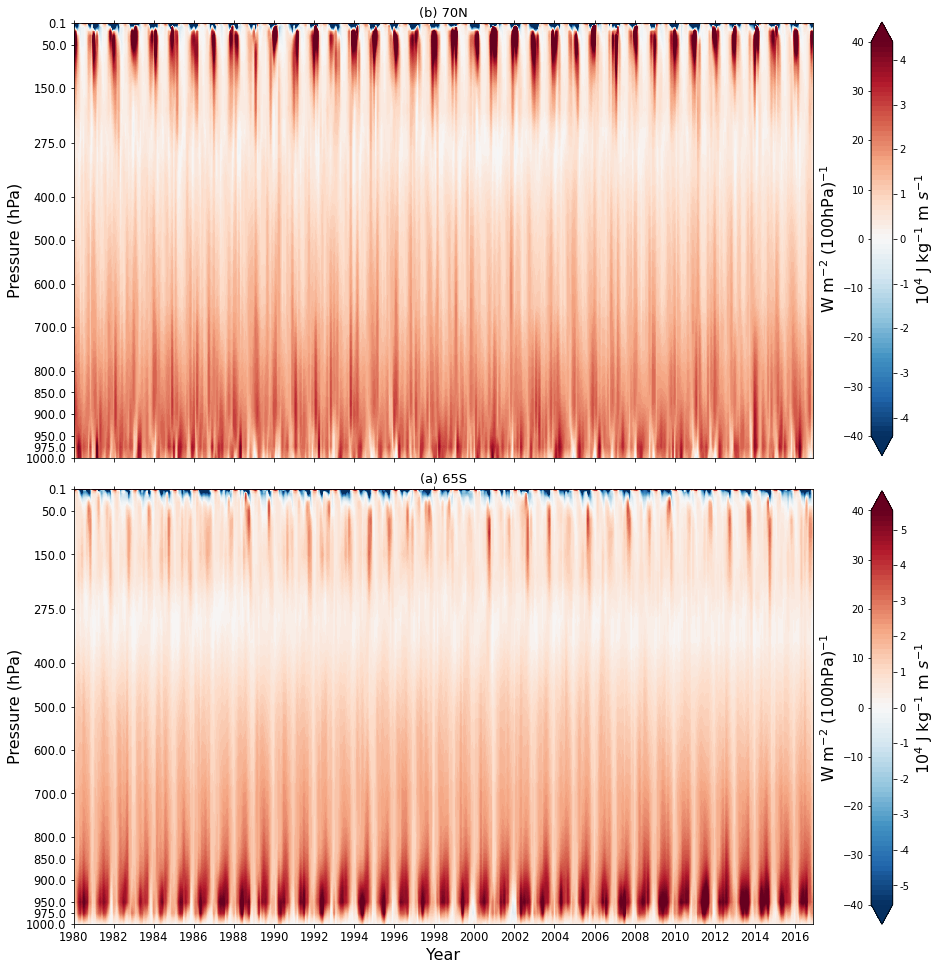

In [25]:
fig = plt.figure()
fig,(ax, ax2) = plt.subplots(2, sharex='col',sharey='row',figsize=(11.5,14))
lev = np.arange(-40., 41, 1)
yticks = np.array([1000,975,950,900,850,800,700,600, 500,400,275, 150, 50, .1])
ax.set_yticks((yticks))
ax.set_yticklabels(yticks)
xticks = np.arange('1980', '2018', dtype='datetime64[2Y]')
ax.set_xticks((xticks))
ax.set_xticklabels(xticks)
cax = ax.contourf(np.arange('1980-01', '2017-01', dtype='datetime64[M]'),merra_ET.lev,((monthly(MSE_H)).transpose('lev','time'))*h()
                      ,cmap=plt.cm.RdBu_r,levels=lev,extend='both')
cax = ax.contourf(np.arange('1980-01', '2017-01', dtype='datetime64[M]'),merra_ET.lev,((monthly(MSE_H)).transpose('lev','time'))*h()
                      ,cmap=plt.cm.RdBu_r,levels=lev,extend='both')
ax.tick_params(which='major', top=True)
ax.set_title('(b) 70N', fontsize = 13)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.axes.invert_yaxis()
cbar = fig.colorbar(cax,ax=ax,ticks=[-40,-30,-20,-10,0,10,20,30,40],cax = fig.add_axes([1.0499999999999, 0.511, 0.026, 0.43]))
cbar.set_label(label='W m$^{-2}$ (100hPa)$^{-1}$',fontsize=16)
cbar3 = fig.colorbar(cax,ax=ax,ticks=[np.array([-4,-3,-2,-1,0,1,2,3,4])*(h()*10**4)],cax = fig.add_axes([1.05, 0.511, 0.026, 0.43]))
cbar3.ax.set_yticklabels(np.array([-4,-3,-2,-1,0,1,2,3,4]))
cbar3.set_label('$10^4$ J kg$^{-1}$ m $s^{-1}$', fontsize=16)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')

ax2.set_yticks((yticks))
ax2.set_yticklabels(yticks)
ax2.set_xticks((xticks))
ax2.set_xticklabels(xticks)
cax2 = ax2.contourf(np.arange('1980-01', '2017-01', dtype='datetime64[M]'),merra_ET2.lev,(-((MSE_H2).transpose('lev','time'))*h(circ=c2,area=a2))
                    ,cmap=plt.cm.RdBu_r,levels=lev,extend='both')
cax2 = ax2.contourf(np.arange('1980-01', '2017-01', dtype='datetime64[M]'),merra_ET2.lev,(-((MSE_H2).transpose('lev','time'))*h(circ=c2,area=a2))
                    ,cmap=plt.cm.RdBu_r,levels=lev,extend='both')
ax2.tick_params(which='major', top=True)
ax2.set_title('(a) 65S', fontsize = 13)
ax2.set_ylabel('Pressure (hPa)', fontsize=16 )
ax2.set_xlabel('Year', fontsize=16 )
ax2.axes.invert_yaxis()
cbar2 = fig.colorbar(cax2,ax=ax2,ticks=[-40,-30,-20,-10,0,10,20,30,40],cax = fig.add_axes([1.0499999999999, 0.046, 0.026, 0.43]))
cbar2.set_label(label='W m$^{-2}$ (100hPa)$^{-1}$',fontsize=16)
cbar4 = fig.colorbar(cax2,ax=ax2,ticks=[np.array([-5,-4,-3,-2,-1,0,1,2,3,4,5])*(h(circ=c2,area=a2)*10**4)],cax = fig.add_axes([1.05, 0.046, 0.026, 0.43]))
cbar4.ax.set_yticklabels(np.array([-5,-4,-3,-2,-1,0,1,2,3,4,5]))
cbar4.set_label('$10^4$ J kg$^{-1}$ m $s^{-1}$', fontsize=16)
cbar2.ax.yaxis.set_ticks_position('left')
cbar2.ax.yaxis.set_label_position('left')
fig.tight_layout()
fig.subplots_adjust(top=.94,right=.98)

ax.tick_params(axis='both',which='major', labelsize=11.5)
ax2.tick_params(axis='both',which='major', labelsize=11.5)

#plt.savefig('MSEseriesJCLI2.pdf',bbox_inches='tight')

## Figure 2

<Figure size 432x288 with 0 Axes>

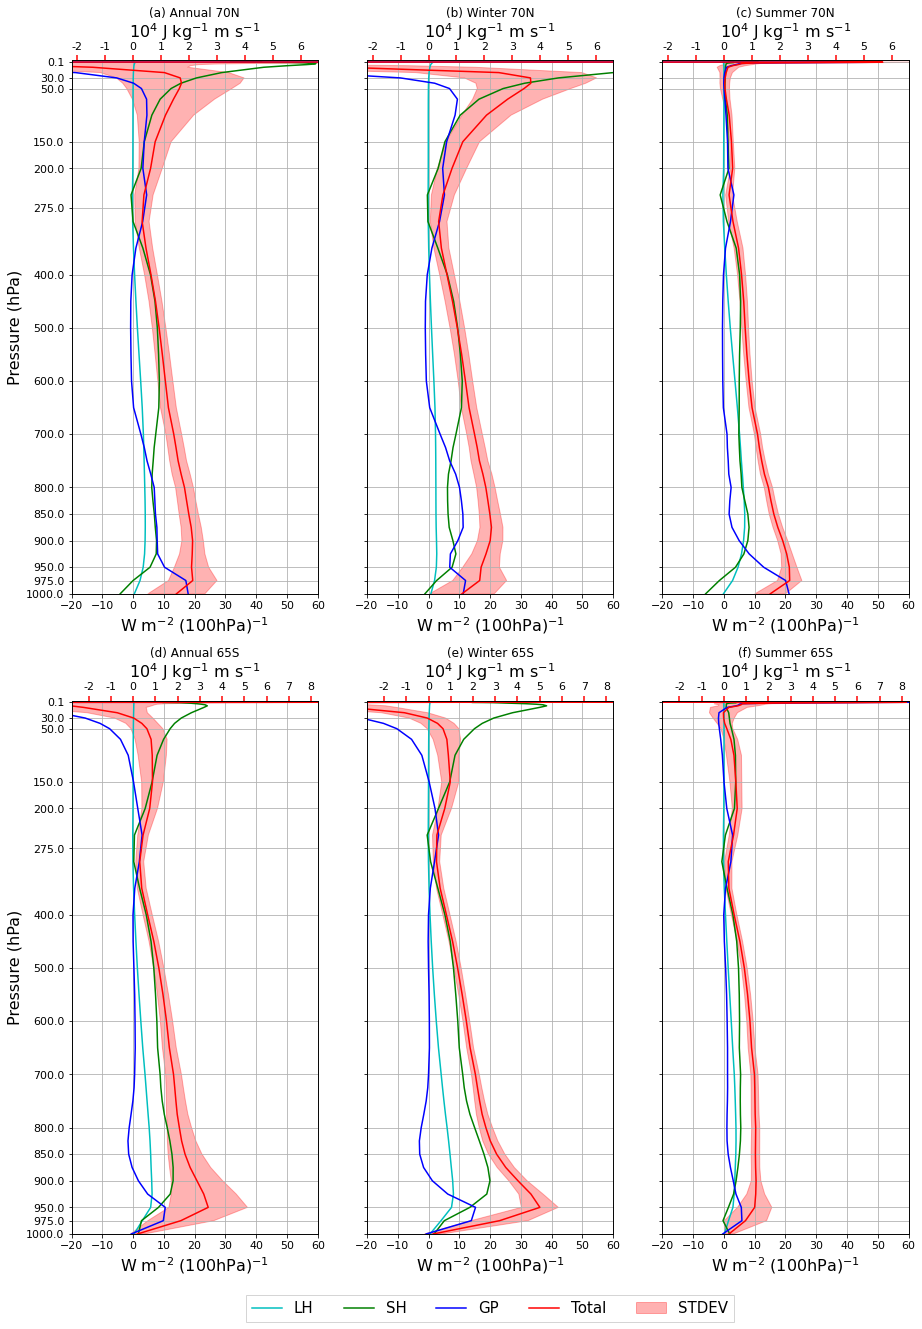

In [26]:
fig = plt.figure()
fig,((ax, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharey='row',figsize=(15,20))
array1=LH_H*h()
array2=SH_H*h()
array3=GP_H*h()
label5='STDEV'
str1='(a) Annual'
label1='LH'
label2='SH'
label3='GP'
label4='Total'
lev=merra_ET.lev
levm = lev
yticks = np.array([1000.,975,950,900,850,800,700,600, 500,400,275,200, 150, 50,30, .1])
ax.set_yticks((yticks))
ax.set_yticklabels(yticks)
ax.plot((array1.mean('time')),levm,ls='solid',lw=1.5,label=label1,color='c')
ax.plot((array2.mean('time')),levm,ls='solid',lw=1.5,label=label2,color='g')
ax.plot((array3.mean('time')),levm,ls='solid',lw=1.5,label=label3,color='b')
ax.plot((MSE_H*h()).mean('time'),levm,ls='solid',lw=1.5,label=label4,color='r')
ax.fill_betweenx(levm,((MSE_H*h()).mean('time'))+(monthly_weight(monthly(MSE_H*h())).std('time'))
                     ,((MSE_H*h()).mean('time'))-(monthly_weight(monthly(MSE_H*h())).std('time'))
                     ,label=label4,color='r',alpha=.3)

ax.grid()
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_title('{} 70N'.format(str1), fontsize = 12,y=1.07)
ax.axes.invert_yaxis()
ax.axes.set_ybound(1000.,-3.)
ax.axes.set_xbound(-20,60)
ax.set_xlabel('W m$^{-2}$ (100hPa)$^{-1}$', fontsize=16)
ax.set_yticklabels(yticks)
str1='(b) Winter'
array1=LH_H.sel(time=winter_nh_d)*h()
array2=SH_H.sel(time=winter_nh_d)*h()
array3=GP_H.sel(time=winter_nh_d)*h()
ax2.plot((array1.mean('time')),levm,ls='solid',lw=1.5,label=label1,color='c')
ax2.plot((array2.mean('time')),levm,ls='solid',lw=1.5,label=label2,color='g')
ax2.plot((array3.mean('time')),levm,ls='solid',lw=1.5,label=label3,color='b')
ax2.plot((MSE_H.sel(time=winter_nh_d)*h()).mean('time'),levm,ls='solid',lw=1.5,label=label4,color='r')
ax2.fill_betweenx(levm,((MSE_H.sel(time=winter_nh_d)*h()).mean('time'))+(monthly_weight(monthly(MSE_H*h()).sel(time=winter_nh_m)).std('time'))
                     ,((MSE_H.sel(time=winter_nh_d)*h()).mean('time'))-(monthly_weight(monthly(MSE_H*h()).sel(time=winter_nh_m)).std('time'))
                     ,label=label4,color='r',alpha=.3)
ax2.grid()
ax2.set_title('{} 70N'.format(str1), fontsize = 12,y=1.07)
ax2.axes.set_ybound(1000.,-3.)
ax2.axes.set_xbound(-20,60)
ax2.set_xlabel('W m$^{-2}$ (100hPa)$^{-1}$', fontsize=16)
ax2.set_yticklabels(yticks)
str1='(c) Summer'
array1=LH_H.sel(time=summer_nh_d).mean('time')*h()
array2=SH_H.sel(time=summer_nh_d).mean('time')*h()
array3=GP_H.sel(time=summer_nh_d).mean('time')*h()
ax3.plot((array1),levm,ls='solid',lw=1.5,label=label1,color='c')
ax3.plot((array2),levm,ls='solid',lw=1.5,label=label2,color='g')
ax3.plot((array3),levm,ls='solid',lw=1.5,label=label3,color='b')
ax3.plot((MSE_H.sel(time=summer_nh_d)*h()).mean('time'),levm,ls='solid',lw=1.5,label=label4,color='r')
ax3.fill_betweenx(levm,((MSE_H.sel(time=summer_nh_d)*h()).mean('time'))+(monthly_weight(monthly(MSE_H*h()).sel(time=summer_nh_m)).std('time'))
                     ,((MSE_H.sel(time=summer_nh_d)*h()).mean('time'))-(monthly_weight(monthly(MSE_H*h()).sel(time=summer_nh_m)).std('time'))
                     ,label=label4,color='r',alpha=.3)
ax3.grid()
ax3.set_title('{} 70N'.format(str1), fontsize = 12,y=1.07)
ax3.axes.set_ybound(1000.,-3.)
ax3.axes.set_xbound(-20,60)
ax3.set_xlabel('W m$^{-2}$ (100hPa)$^{-1}$', fontsize=16)
ax3.set_yticklabels(yticks)
str1='(d) Annual'
array1=monthly_weight(LH_H2).mean('time')*h(circ=c2,area=a2)
array2=monthly_weight(SH_H2).mean('time')*h(circ=c2,area=a2)
array3=monthly_weight(GP_H2).mean('time')*h(circ=c2,area=a2)
ax4.plot((-(array1)),levm,ls='solid',lw=1.5,label=label1,color='c')
ax4.plot((-(array2)),levm,ls='solid',lw=1.5,label=label2,color='g')
ax4.plot((-(array3)),levm,ls='solid',lw=1.5,label=label3,color='b')
ax4.plot(-(monthly_weight(MSE_H2)*h(circ=c2,area=a2)).mean('time'),levm,ls='solid',lw=1.5,label=label4,color='r')
ax4.fill_betweenx(levm,((-monthly_weight(MSE_H2)*h(circ=c2,area=a2)).mean('time'))+(monthly_weight(MSE_H2)*(h(circ=c2,area=a2))).std('time')
                     ,((-monthly_weight(MSE_H2)*h(circ=c2,area=a2)).mean('time'))-(monthly_weight(MSE_H2)*(h(circ=c2,area=a2))).std('time')
                     ,label=label5,color='r',alpha=.3)
ax4.grid()
ax4.set_xlabel('W m$^{-2}$ (100hPa)$^{-1}$', fontsize=16)
ax4.set_ylabel('Pressure (hPa)', fontsize=16 )
ax4.set_title('{} 65S'.format(str1), fontsize = 12,y=1.07)
ax4.axes.invert_yaxis()
ax4.axes.set_ybound(1000.,-3.)
ax4.axes.set_xbound(-20,60)
ax4.set_yticks((yticks))
ax4.set_yticklabels(yticks)
str1='(e) Winter'
array1=LH_H2.sel(time=winter_sh).mean('time')*(h(circ=c2,area=a2))
array2=SH_H2.sel(time=winter_sh).mean('time')*(h(circ=c2,area=a2))
array3=GP_H2.sel(time=winter_sh).mean('time')*(h(circ=c2,area=a2))
ax5.plot((-(array1)),levm,ls='solid',lw=1.5,label=label1,color='c')
ax5.plot((-(array2)),levm,ls='solid',lw=1.5,label=label2,color='g')
ax5.plot((-(array3)),levm,ls='solid',lw=1.5,label=label3,color='b')
ax5.plot(-(monthly_weight(MSE_H2.sel(time=winter_sh))*h(circ=c2,area=a2)).mean('time'),levm,ls='solid',lw=1.5,label=label4,color='r')
ax5.fill_betweenx(levm,((-monthly_weight(MSE_H2.sel(time=winter_sh))*h(circ=c2,area=a2)).mean('time'))+(monthly_weight(MSE_H2.sel(time=winter_sh))*(h(circ=c2,area=a2))).std('time')
                     ,((-monthly_weight(MSE_H2.sel(time=winter_sh))*h(circ=c2,area=a2)).mean('time'))-(monthly_weight(MSE_H2.sel(time=winter_sh))*(h(circ=c2,area=a2))).std('time')
                     ,label=label5,color='r',alpha=.3)
ax5.grid()
ax5.set_xlabel('W m$^{-2}$ (100hPa)$^{-1}$', fontsize=16)
ax5.set_title('{} 65S'.format(str1), fontsize = 12,y=1.07)
ax5.axes.invert_yaxis()
ax5.axes.set_ybound(1000.,-3.)
ax5.axes.set_xbound(-20,60)
ax5.set_yticks((yticks))
ax5.set_yticklabels(yticks)
lgd=ax5.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=False, shadow=False, ncol=6, fontsize=15)
str1='(f) Summer'
array1=LH_H2.sel(time=summer_sh).mean('time')*(h(circ=c2,area=a2))
array2=SH_H2.sel(time=summer_sh).mean('time')*(h(circ=c2,area=a2))
array3=GP_H2.sel(time=summer_sh).mean('time')*(h(circ=c2,area=a2))
ax6.plot(-((array1)),levm,ls='solid',lw=1.5,label=label1,color='c')
ax6.plot(-((array2)),levm,ls='solid',lw=1.5,label=label2,color='g')
ax6.plot(-((array3)),levm,ls='solid',lw=1.5,label=label3,color='b')
ax6.plot(-(monthly_weight(MSE_H2.sel(time=summer_sh))*h(circ=c2,area=a2)).mean('time'),levm,ls='solid',lw=1.5,label=label4,color='r')
ax6.fill_betweenx(levm,((-monthly_weight(MSE_H2.sel(time=summer_sh))*h(circ=c2,area=a2)).mean('time'))+(monthly_weight(MSE_H2.sel(time=summer_sh))*(h(circ=c2,area=a2))).std('time')
                     ,((-monthly_weight(MSE_H2.sel(time=summer_sh))*h(circ=c2,area=a2)).mean('time'))-(monthly_weight(MSE_H2.sel(time=summer_sh))*(h(circ=c2,area=a2))).std('time')
                     ,label=label5,color='r',alpha=.3)
ax6.grid()
ax6.set_xlabel('W m$^{-2}$ (100hPa)$^{-1}$', fontsize=16)
ax6.set_title('{} 65S'.format(str1), fontsize = 12,y=1.07)
ax6.axes.invert_yaxis()
ax6.axes.set_ybound(1000.,-3.)
ax6.axes.set_xbound(-20,60)
ax6.set_yticks((yticks))
ax6.set_yticklabels(yticks)
#tle=fig.suptitle('Vertical Mean MSE Flux',fontsize=18)
#fig.tight_layout()
fig.subplots_adjust(top=.94)
ax7=ax.twiny()
ax7.axes.set_xbound(-20,60)
ax7.set_xticks(np.array([-2,-1,0,1,2,3,4,5,6])*(h()*10**4))
ax7.set_xticklabels(np.array([-2,-1,0,1,2,3,4,5,6]))
ax7.tick_params(which='major', length=5, color='r',top=True,bottom=False,direction='out',width=1.5)
ax7.set_xlabel('$10^4$ J kg$^{-1}$ m s$^{-1}$', fontsize=16)
ax8=ax2.twiny()
ax8.axes.set_xbound(-20,60)
ax8.set_xticks(np.array([-2,-1,0,1,2,3,4,5,6])*(h()*10**4))
ax8.set_xticklabels(np.array([-2,-1,0,1,2,3,4,5,6]))
ax8.tick_params(which='major', length=5, color='r',top=True,bottom=False,direction='out',width=1.5)
ax8.set_xlabel('$10^4$ J kg$^{-1}$ m s$^{-1}$', fontsize=16)
ax9=ax3.twiny()
ax9.axes.set_xbound(-20,60)
ax9.set_xticks(np.array([-2,-1,0,1,2,3,4,5,6])*(h()*10**4))
ax9.set_xticklabels(np.array([-2,-1,0,1,2,3,4,5,6]))
ax9.tick_params(which='major', length=5, color='r',top=True,bottom=False,direction='out',width=1.5)
ax9.set_xlabel('$10^4$ J kg$^{-1}$ m s$^{-1}$', fontsize=16)
ax10=ax4.twiny()
ax10.axes.set_xbound(-20,60)
ax10.set_xticks(np.array([-2,-1,0,1,2,3,4,5,6,7,8])*(h(circ=c2,area=a2)*10**4))
ax10.set_xticklabels(np.array([-2,-1,0,1,2,3,4,5,6,7,8]))
ax10.tick_params(which='major', length=5, color='r',top=True,bottom=False,direction='out',width=1.5)
ax10.set_xlabel('$10^4$ J kg$^{-1}$ m s$^{-1}$', fontsize=16)
ax11=ax5.twiny()
ax11.axes.set_xbound(-20,60)
ax11.set_xticks(np.array([-2,-1,0,1,2,3,4,5,6,7,8])*(h(circ=c2,area=a2)*10**4))
ax11.set_xticklabels(np.array([-2,-1,0,1,2,3,4,5,6,7,8]))
ax11.tick_params(which='major', length=5, color='r',top=True,bottom=False,direction='out',width=1.5)
ax11.set_xlabel('$10^4$ J kg$^{-1}$ m s$^{-1}$', fontsize=16)
ax12=ax6.twiny()
ax12.axes.set_xbound(-20,60)
ax12.set_xticks(np.array([-2,-1,0,1,2,3,4,5,6,7,8])*(h(circ=c2,area=a2)*10**4))
ax12.set_xticklabels(np.array([-2,-1,0,1,2,3,4,5,6,7,8]))
ax12.tick_params(which='major', length=5, color='r',top=True,bottom=False,direction='out',width=1.5)
ax12.set_xlabel('$10^4$ J kg$^{-1}$ m s$^{-1}$', fontsize=16)

ax.set_xticks(np.array([-20,-10,0,10,20,30,40,50,60]))
ax2.set_xticks(np.array([-20,-10,0,10,20,30,40,50,60]))
ax3.set_xticks(np.array([-20,-10,0,10,20,30,40,50,60]))
ax4.set_xticks(np.array([-20,-10,0,10,20,30,40,50,60]))
ax5.set_xticks(np.array([-20,-10,0,10,20,30,40,50,60]))
ax6.set_xticks(np.array([-20,-10,0,10,20,30,40,50,60]))

ax.tick_params(axis='both',which='major', labelsize=11)
ax2.tick_params(axis='both',which='major', labelsize=11)
ax3.tick_params(axis='both',which='major', labelsize=11)
ax4.tick_params(axis='both',which='major', labelsize=11)
ax5.tick_params(axis='both',which='major', labelsize=11)
ax6.tick_params(axis='both',which='major', labelsize=11)

ax7.tick_params(axis='both',which='major', labelsize=11)
ax8.tick_params(axis='both',which='major', labelsize=11)
ax9.tick_params(axis='both',which='major', labelsize=11)
ax10.tick_params(axis='both',which='major', labelsize=11)
ax11.tick_params(axis='both',which='major', labelsize=11)
ax12.tick_params(axis='both',which='major', labelsize=11)

#plt.savefig('OverlandJCLI2.pdf', bbox_inches='tight')

## Figure 3

In [27]:
#monthly mean annual cycles
NH_MAC = periodic(ann_cycle_monthly(ufunc(MSE_H*c/a,integrate)).roll(time=6))
NH_STD = periodic(ann_cycle_monthly_std(ufunc(MSE_H*c/a,integrate)).roll(time=6))
NH_MAC_STRAT = periodic(ann_cycle_monthly(ufunc(MSE_H*c/a,integrate_strat)).roll(time=6))
NH_STD_STRAT = periodic(ann_cycle_monthly_std(ufunc(MSE_H*c/a,integrate_strat)).roll(time=6))
NH_MAC_TROP = periodic(ann_cycle_monthly(ufunc(MSE_H*c/a,integrate_trop)).roll(time=6))
NH_STD_TROP = periodic(ann_cycle_monthly_std(ufunc(MSE_H*c/a,integrate_trop)).roll(time=6))
SH_MAC = -periodic(ann_cycle_monthly2(ufunc(MSE_H2*c2/a2,integrate)))
SH_STD = -periodic(ann_cycle_monthly_std2(ufunc(MSE_H2*c2/a2,integrate)))
SH_MAC_STRAT = -periodic(ann_cycle_monthly2(ufunc(MSE_H2*c2/a2,integrate_strat)))
SH_STD_STRAT = -periodic(ann_cycle_monthly_std2(ufunc(MSE_H2*c2/a2,integrate_strat)))
SH_MAC_TROP = -periodic(ann_cycle_monthly2(ufunc(MSE_H2*c2/a2,integrate_trop)))
SH_STD_TROP = -periodic(ann_cycle_monthly_std2(ufunc(MSE_H2*c2/a2,integrate_trop)))

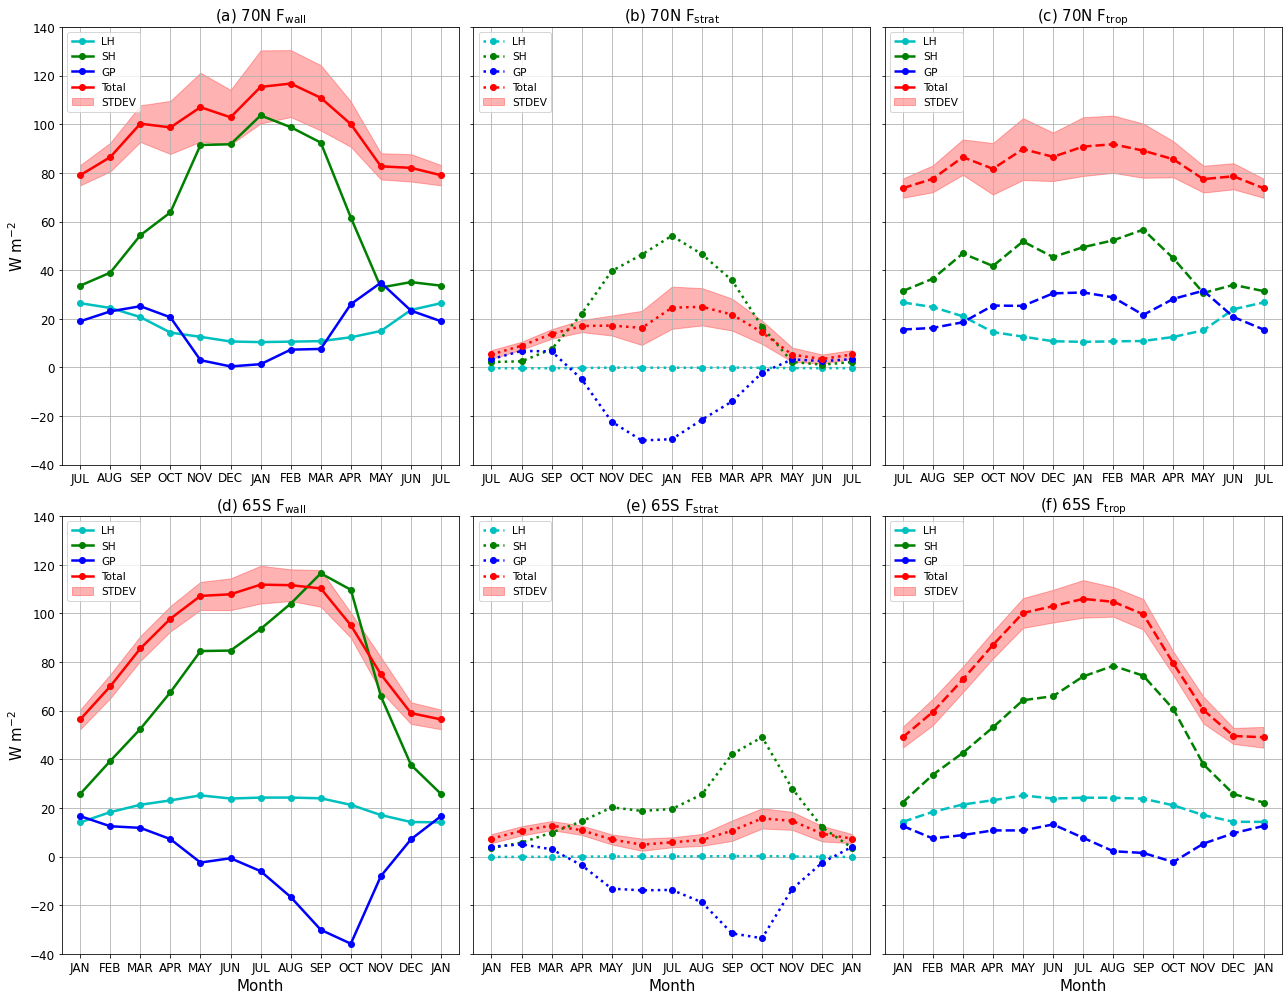

In [28]:
fig = plt.figure( figsize=(18,14) )

ax = fig.add_subplot(2,3,1)
ax.set_xticks(np.linspace(0,12,13))
ax.set_xticklabels([])
ax.plot(np.arange(0,13,1),periodic(ann_cycle_monthly(ufunc(LH_H*c/a,integrate)).roll(time=6)),'co',ls='-',lw=2.5,label='LH')
ax.plot(np.arange(0,13,1),periodic(ann_cycle_monthly(ufunc(SH_H*c/a,integrate)).roll(time=6)),'go',ls='-',lw=2.5,label='SH')
ax.plot(np.arange(0,13,1),periodic(ann_cycle_monthly(ufunc(GP_H*c/a,integrate)).roll(time=6)),'bo',ls='-',lw=2.5,label='GP')
ax.plot(np.arange(0,13,1),NH_MAC,'ro',ls='-',lw=2.5,label='Total')
ax.fill_between(np.arange(0,13,1),(NH_MAC
                 -(NH_STD))
                     ,(NH_MAC
                       +(NH_STD))
                       ,color='r',alpha=.3,label='STDEV')
ax2 = fig.add_subplot(2,3,2)
ax2.set_xticks(np.linspace(0,12,13))
ax2.set_xticklabels([])
ax2.plot(np.arange(0,13,1),periodic(ann_cycle_monthly(ufunc(LH_H*c/a,integrate_strat)).roll(time=6)),'co',ls=':',lw=2.5,label='LH')
ax2.plot(np.arange(0,13,1),periodic(ann_cycle_monthly(ufunc(SH_H*c/a,integrate_strat)).roll(time=6)),'go',ls=':',lw=2.5,label='SH')
ax2.plot(np.arange(0,13,1),periodic(ann_cycle_monthly(ufunc(GP_H*c/a,integrate_strat)).roll(time=6)),'bo',ls=':',lw=2.5,label='GP')
ax2.plot(np.arange(0,13,1),NH_MAC_STRAT,'ro',ls=':',lw=2.5,label='Total')
ax2.fill_between(np.arange(0,13,1),(NH_MAC_STRAT
                 -(NH_STD_STRAT))
                     ,(NH_MAC_STRAT
                       +(NH_STD_STRAT))
                       ,color='r',alpha=.3,label='STDEV')
ax3 = fig.add_subplot(2,3,3)
ax3.set_xticks(np.linspace(0,12,13))
ax3.set_xticklabels([])
ax3.plot(np.arange(0,13,1),periodic(ann_cycle_monthly(ufunc(LH_H*c/a,integrate_trop)).roll(time=6)),'co',ls='--',lw=2.5,label='LH')
ax3.plot(np.arange(0,13,1),periodic(ann_cycle_monthly(ufunc(SH_H*c/a,integrate_trop)).roll(time=6)),'go',ls='--',lw=2.5,label='SH')
ax3.plot(np.arange(0,13,1),periodic(ann_cycle_monthly(ufunc(GP_H*c/a,integrate_trop)).roll(time=6)),'bo',ls='--',lw=2.5,label='GP')
ax3.plot(np.arange(0,13,1),NH_MAC_TROP,'ro',ls='--',lw=2.5,label='Total')
ax3.fill_between(np.arange(0,13,1),(NH_MAC_TROP
                 -(NH_STD_TROP))
                     ,(NH_MAC_TROP
                       +(NH_STD_TROP))
                       ,color='r',alpha=.3,label='STDEV')

ax4 = fig.add_subplot(2,3,4)
ax4.set_xticks(np.linspace(0,12,13))
ax4.set_xticklabels([])
ax4.plot(np.arange(0,13,1),-periodic(ann_cycle_monthly2(ufunc(LH_H2*c2/a2,integrate))),'co',ls='-',lw=2.5,label='LH')
ax4.plot(np.arange(0,13,1),-periodic(ann_cycle_monthly2(ufunc(SH_H2*c2/a2,integrate))),'go',ls='-',lw=2.5,label='SH')
ax4.plot(np.arange(0,13,1),-periodic(ann_cycle_monthly2(ufunc(GP_H2*c2/a2,integrate))),'bo',ls='-',lw=2.5,label='GP')
ax4.plot(np.arange(0,13,1),SH_MAC,'ro',ls='-',lw=2.5,label='Total')
ax4.fill_between(np.arange(0,13,1),(SH_MAC
                 -(SH_STD))
                     ,(SH_MAC
                       +(SH_STD))
                       ,color='r',alpha=.3,label='STDEV')
ax5 = fig.add_subplot(2,3,5)
ax5.set_xticks(np.linspace(0,12,13))
ax5.set_xticklabels([])
ax5.plot(np.arange(0,13,1),-periodic(ann_cycle_monthly2(ufunc(LH_H2*c2/a2,integrate_strat))),'co',ls=':',lw=2.5,label='LH')
ax5.plot(np.arange(0,13,1),-periodic(ann_cycle_monthly2(ufunc(SH_H2*c2/a2,integrate_strat))),'go',ls=':',lw=2.5,label='SH')
ax5.plot(np.arange(0,13,1),-periodic(ann_cycle_monthly2(ufunc(GP_H2*c2/a2,integrate_strat))),'bo',ls=':',lw=2.5,label='GP')
ax5.plot(np.arange(0,13,1),SH_MAC_STRAT,'ro',ls=':',lw=2.5,label='Total')
ax5.fill_between(np.arange(0,13,1),(SH_MAC_STRAT
                 -(SH_STD_STRAT))
                     ,(SH_MAC_STRAT
                       +(SH_STD_STRAT))
                       ,color='r',alpha=.3,label='STDEV')
ax6 = fig.add_subplot(2,3,6)
ax6.set_xticks(np.linspace(0,12,13))
ax6.set_xticklabels([])
ax6.plot(np.arange(0,13,1),-periodic(ann_cycle_monthly2(ufunc(LH_H2*c2/a2,integrate_trop))),'co',ls='--',lw=2.5,label='LH')
ax6.plot(np.arange(0,13,1),-periodic(ann_cycle_monthly2(ufunc(SH_H2*c2/a2,integrate_trop))),'go',ls='--',lw=2.5,label='SH')
ax6.plot(np.arange(0,13,1),-periodic(ann_cycle_monthly2(ufunc(GP_H2*c2/a2,integrate_trop))),'bo',ls='--',lw=2.5,label='GP')
ax6.plot(np.arange(0,13,1),SH_MAC_TROP,'ro',ls='--',lw=2.5,label='Total')
ax6.fill_between(np.arange(0,13,1),(SH_MAC_TROP
                 -(SH_STD_TROP))
                     ,(SH_MAC_TROP
                       +(SH_STD_TROP))
                       ,color='r',alpha=.3,label='STDEV')
ax.set_title('(a) 70N $\mathregular{F_{wall}}$',fontsize=15)
ax2.set_title('(b) 70N $\mathregular{F_{strat}}$',fontsize=15)
ax3.set_title('(c) 70N $\mathregular{F_{trop}}$',fontsize=15)
ax4.set_title('(d) 65S $\mathregular{F_{wall}}$',fontsize=15)
ax5.set_title('(e) 65S $\mathregular{F_{strat}}$',fontsize=15)
ax6.set_title('(f) 65S $\mathregular{F_{trop}}$',fontsize=15)

ax.set_ylabel('W m$^{-2}$',fontsize=15)
ax.axes.set_ybound(-40,140)
ax.set_xticklabels(['JUL','AUG','SEP','OCT','NOV','DEC','JAN','FEB','MAR','APR','MAY',
                   'JUN','JUL'])
ax.legend(loc='upper left',fontsize=10.5)
ax.grid()
ax2.axes.set_ybound(-40,140)
ax2.set_xticklabels(['JUL','AUG','SEP','OCT','NOV','DEC','JAN','FEB','MAR','APR','MAY',
                   'JUN','JUL'])
ax2.legend(loc='upper left',fontsize=10.5)
ax2.set_yticklabels([])
ax2.grid()
ax3.axes.set_ybound(-40,140)
ax3.set_xticklabels(['JUL','AUG','SEP','OCT','NOV','DEC','JAN','FEB','MAR','APR','MAY',
                   'JUN','JUL'])
ax3.legend(loc='upper left',fontsize=10.5)
ax3.set_yticklabels([])
ax3.grid()

ax4.set_ylabel('W m$^{-2}$',fontsize=15)
ax4.axes.set_ybound(-40,140)
ax4.set_xticklabels(['JAN','FEB','MAR','APR','MAY',
                   'JUN','JUL','AUG','SEP','OCT','NOV','DEC','JAN'])
ax4.legend(loc='upper left',fontsize=10.5)
ax4.grid()
ax5.axes.set_ybound(-40,140)
ax5.set_xticklabels(['JAN','FEB','MAR','APR','MAY',
                   'JUN','JUL','AUG','SEP','OCT','NOV','DEC','JAN'])
ax5.legend(loc='upper left',fontsize=10.5)
ax5.set_yticklabels([])
ax5.grid()
ax6.axes.set_ybound(-40,140)
ax6.set_xticklabels(['JAN','FEB','MAR','APR','MAY',
                   'JUN','JUL','AUG','SEP','OCT','NOV','DEC','JAN'])
ax6.legend(loc='upper left',fontsize=10.5)
ax6.set_yticklabels([])
ax6.grid()
ax4.set_xlabel('Month', fontsize=15 )
ax5.set_xlabel('Month', fontsize=15 )
ax6.set_xlabel('Month', fontsize=15 )

ax.tick_params(axis='both',which='major', labelsize=12)
ax2.tick_params(axis='both',which='major', labelsize=12)
ax3.tick_params(axis='both',which='major', labelsize=12)
ax4.tick_params(axis='both',which='major', labelsize=12)
ax5.tick_params(axis='both',which='major', labelsize=12)
ax6.tick_params(axis='both',which='major', labelsize=12)

fig.tight_layout()
#plt.savefig('IntegrcycleJCLI2.pdf', bbox_inches='tight')

## Table 1 and Table 2

In [29]:
season=pd.Index(['Annual','Winter 3m','Spring','Summer','Fall','Winter 5m'],name='season')
Fwall_70=xr.concat([(ufunc(MSE_H.sel(time=s),integrate)*c/a).mean('time')
           for s in [MSE_H.time,winter_nh_3m_d,spring_nh_d,summer_nh_d,fall_nh_d,winter_nh_d]],season)
Ftrop_70=xr.concat([(ufunc(MSE_H.sel(time=s),integrate_trop)*c/a).mean('time')
           for s in [MSE_H.time,winter_nh_3m_d,spring_nh_d,summer_nh_d,fall_nh_d,winter_nh_d]],season)
Fstrat_70=xr.concat([(ufunc(MSE_H.sel(time=s),integrate_strat)*c/a).mean('time')
           for s in [MSE_H.time,winter_nh_3m_d,spring_nh_d,summer_nh_d,fall_nh_d,winter_nh_d]],season)

Fwall_70_sh=xr.concat([(ufunc(SH_H.sel(time=s),integrate)*c/a).mean('time')
           for s in [MSE_H.time,winter_nh_3m_d,spring_nh_d,summer_nh_d,fall_nh_d,winter_nh_d]],season)
Ftrop_70_sh=xr.concat([(ufunc(SH_H.sel(time=s),integrate_trop)*c/a).mean('time')
           for s in [MSE_H.time,winter_nh_3m_d,spring_nh_d,summer_nh_d,fall_nh_d,winter_nh_d]],season)
Fstrat_70_sh=xr.concat([(ufunc(SH_H.sel(time=s),integrate_strat)*c/a).mean('time')
           for s in [MSE_H.time,winter_nh_3m_d,spring_nh_d,summer_nh_d,fall_nh_d,winter_nh_d]],season)

Fwall_70_lh=xr.concat([(ufunc(LH_H.sel(time=s),integrate)*c/a).mean('time')
           for s in [MSE_H.time,winter_nh_3m_d,spring_nh_d,summer_nh_d,fall_nh_d,winter_nh_d]],season)
Ftrop_70_lh=xr.concat([(ufunc(LH_H.sel(time=s),integrate_trop)*c/a).mean('time')
           for s in [MSE_H.time,winter_nh_3m_d,spring_nh_d,summer_nh_d,fall_nh_d,winter_nh_d]],season)
Fstrat_70_lh=xr.concat([(ufunc(LH_H.sel(time=s),integrate_strat)*c/a).mean('time')
           for s in [MSE_H.time,winter_nh_3m_d,spring_nh_d,summer_nh_d,fall_nh_d,winter_nh_d]],season)

Fwall_70_gp=xr.concat([(ufunc(GP_H.sel(time=s),integrate)*c/a).mean('time')
           for s in [MSE_H.time,winter_nh_3m_d,spring_nh_d,summer_nh_d,fall_nh_d,winter_nh_d]],season)
Ftrop_70_gp=xr.concat([(ufunc(GP_H.sel(time=s),integrate_trop)*c/a).mean('time')
           for s in [MSE_H.time,winter_nh_3m_d,spring_nh_d,summer_nh_d,fall_nh_d,winter_nh_d]],season)
Fstrat_70_gp=xr.concat([(ufunc(GP_H.sel(time=s),integrate_strat)*c/a).mean('time')
           for s in [MSE_H.time,winter_nh_3m_d,spring_nh_d,summer_nh_d,fall_nh_d,winter_nh_d]],season)



In [30]:
flux_70 = pd.Index(['Fwall','Fwall: SH','Fwall: LH','Fwall: GP',
                'Ftrop','Ftrop: SH','Ftrop: LH','Ftrop: GP',
                'Fstrat','Fstrat: SH','Fstrat: LH','Fstrat: GP'],name='flux: 70N')
xr.concat([Fwall_70,Fwall_70_sh,Fwall_70_lh,Fwall_70_gp,
          Ftrop_70,Ftrop_70_sh,Ftrop_70_lh,Ftrop_70_gp,
          Fstrat_70,Fstrat_70_sh,Fstrat_70_lh,Fstrat_70_gp],flux_70).to_dataframe('').unstack()
#values in W/m2
#note that the values were rounded to 1 decimal place in the paper
#some values required adjustment after rounding so all contributions added to their respective total

\
season         Annual        Fall     Spring     Summer   Winter 3m   
flux: 70N                                                             
Fstrat      14.354637   16.015136  13.802923   5.935777   21.823178   
Fstrat: GP  -8.425989   -6.834138  -4.313538   4.286546  -27.178089   
Fstrat: LH  -0.197881   -0.202986  -0.159573  -0.319037   -0.108301   
Fstrat: SH  22.978507   23.052261  18.276034   1.968268   49.109568   
Ftrop       84.036006   85.941001  84.044793  76.606521   89.678502   
Ftrop: GP   24.426034   23.135496  27.103783  17.487819   30.069108   
Ftrop: LH   16.227814   16.061579  12.896349  25.175840   10.671209   
Ftrop: SH   43.382158   46.743926  44.044661  33.942862   48.938184   
Fwall       98.390642  101.956137  97.847716  82.542298  111.501680   
Fwall: GP   16.000045   16.301358  22.790245  21.774365    2.891019   
Fwall: LH   16.029933   15.858592  12.736776  24.856803   10.562909   
Fwall: SH   66.360665   69.796187  62.320695  35.911130   98.047753   

                        
season       Winter 5m  
flux: 70N               
Fstrat       20.893704  
Fstrat: GP  -23.518002  
Fstrat: LH   -0.095296  
Fstrat: SH   44.507002  
Ftrop        89.592329  
Ftrop: GP    27.391276  
Ftrop: LH    11.109403  
Ftrop: SH    51.091650  
Fwall       110.486033  
Fwall: GP     3.873273  
Fwall: LH    11.014108  
Fwall: SH    95.598652

In [31]:
Fwall_65=xr.concat([(ufunc(-monthly_weight(MSE_H2.sel(time=s)),integrate)*c2/a2).mean('time')
           for s in [MSE_H2.time,winter_sh_3m,spring_sh,summer_sh,fall_sh,winter_sh]],season)
Ftrop_65=xr.concat([(ufunc(-monthly_weight(MSE_H2.sel(time=s)),integrate_trop)*c2/a2).mean('time')
           for s in [MSE_H2.time,winter_sh_3m,spring_sh,summer_sh,fall_sh,winter_sh]],season)
Fstrat_65=xr.concat([(ufunc(-monthly_weight(MSE_H2.sel(time=s)),integrate_strat)*c2/a2).mean('time')
           for s in [MSE_H2.time,winter_sh_3m,spring_sh,summer_sh,fall_sh,winter_sh]],season)

Fwall_65_sh=xr.concat([(ufunc(-monthly_weight(SH_H2.sel(time=s)),integrate)*c2/a2).mean('time')
           for s in [MSE_H2.time,winter_sh_3m,spring_sh,summer_sh,fall_sh,winter_sh]],season)
Ftrop_65_sh=xr.concat([(ufunc(-monthly_weight(SH_H2.sel(time=s)),integrate_trop)*c2/a2).mean('time')
           for s in [MSE_H2.time,winter_sh_3m,spring_sh,summer_sh,fall_sh,winter_sh]],season)
Fstrat_65_sh=xr.concat([(ufunc(-monthly_weight(SH_H2.sel(time=s)),integrate_strat)*c2/a2).mean('time')
           for s in [MSE_H2.time,winter_sh_3m,spring_sh,summer_sh,fall_sh,winter_sh]],season)

Fwall_65_lh=xr.concat([(ufunc(-monthly_weight(LH_H2.sel(time=s)),integrate)*c2/a2).mean('time')
           for s in [MSE_H2.time,winter_sh_3m,spring_sh,summer_sh,fall_sh,winter_sh]],season)
Ftrop_65_lh=xr.concat([(ufunc(-monthly_weight(LH_H2.sel(time=s)),integrate_trop)*c2/a2).mean('time')
           for s in [MSE_H2.time,winter_sh_3m,spring_sh,summer_sh,fall_sh,winter_sh]],season)
Fstrat_65_lh=xr.concat([(ufunc(-monthly_weight(LH_H2.sel(time=s)),integrate_strat)*c2/a2).mean('time')
           for s in [MSE_H2.time,winter_sh_3m,spring_sh,summer_sh,fall_sh,winter_sh]],season)

Fwall_65_gp=xr.concat([(ufunc(-monthly_weight(GP_H2.sel(time=s)),integrate)*c2/a2).mean('time')
           for s in [MSE_H2.time,winter_sh_3m,spring_sh,summer_sh,fall_sh,winter_sh]],season)
Ftrop_65_gp=xr.concat([(ufunc(-monthly_weight(GP_H2.sel(time=s)),integrate_trop)*c2/a2).mean('time')
           for s in [MSE_H2.time,winter_sh_3m,spring_sh,summer_sh,fall_sh,winter_sh]],season)
Fstrat_65_gp=xr.concat([(ufunc(-monthly_weight(GP_H2.sel(time=s)),integrate_strat)*c2/a2).mean('time')
           for s in [MSE_H2.time,winter_sh_3m,spring_sh,summer_sh,fall_sh,winter_sh]],season)

In [32]:
flux_65 = pd.Index(['Fwall','Fwall: SH','Fwall: LH','Fwall: GP',
                'Ftrop','Ftrop: SH','Ftrop: LH','Ftrop: GP',
                'Fstrat','Fstrat: SH','Fstrat: LH','Fstrat: GP'],name='flux: 65S')
xr.concat([Fwall_65,Fwall_65_sh,Fwall_65_lh,Fwall_65_gp,
          Ftrop_65,Ftrop_65_sh,Ftrop_65_lh,Ftrop_65_gp,
          Fstrat_65,Fstrat_65_sh,Fstrat_65_lh,Fstrat_65_gp],flux_65).to_dataframe('').unstack()

season         Annual       Fall     Spring     Summer   Winter 3m   Winter 5m
flux: 65S                                                                     
Fstrat       9.688461  10.182410  13.683337   9.055965    5.863662    7.034172
Fstrat: GP -11.088356  -4.616316 -26.257354   2.104238  -15.500834  -18.196117
Fstrat: LH  -0.002188  -0.044006   0.129639  -0.140765    0.045207    0.063292
Fstrat: SH  20.779005  14.842732  39.811053   7.092492   21.319289   25.166998
Ftrop       81.006872  86.655719  79.758902  52.481770  104.581220  102.713947
Ftrop: GP    7.286742  10.091822   1.465309   9.939952    7.636492    7.055686
Ftrop: LH   20.896206  23.222095  20.631016  15.558012   24.070452   24.229290
Ftrop: SH   52.823924  53.341802  57.662576  26.983805   72.874276   71.428971
Fwall       90.695333  96.838129  93.442239  61.537735  110.444882  109.748119
Fwall: GP   -3.801614   5.475506 -24.792045  12.044190   -7.864341  -11.140432
Fwall: LH   20.894018  23.178089  20.760655  15.417247   24.115659   24.292582
Fwall: SH   73.602929  68.184534  97.473630  34.076298   94.193565   96.595969

## Sudden Stratospheric Warmings (SSWs) and Downward Surface Flux Events (DSFEs)

In [33]:
def event_count(array,days=1):
    """Computes the cumulative count (count stops at nans).
    Used to count the number of westerly days between sudden stratospheric warmings."""
    df = array.to_dataframe('df')
    df_count = df['df'].groupby(df['df'].isna().cumsum()).expanding().count()
    bin_size = df['df'].groupby(df['df'].isna().cumsum()).transform(np.size)
    da_size = xr.DataArray(bin_size.values,coords=[array.time],dims=['time']).dropna('time')
    da_count = xr.DataArray(df_count.values,coords=[array.time],dims=['time']).where(da_size>days).dropna('time')
    
    end = da_count.where(((da_count.time.shift(time=-1) - da_count.time) > np.array(0, dtype='timedelta64[D]')))
    end[-1] = da_count[-1]
    end = end.dropna('time')
    
    count = xr.DataArray(end.values,coords=[end.time+np.array(1, dtype='timedelta64[D]')],dims=['time'])
    return count

In [34]:
u_10mb_w = u_10mb.sel(time=winter_nh_d)
westerly_count=event_count(u_10mb_w.where(u_10mb_w>0))

In [35]:
weak = u_10mb_w.where((u_10mb_w < u_10mb_w.shift(time=1).fillna(0)) & (u_10mb_w.shift(time=1).fillna(0) > 0.) 
                    & (u_10mb_w < 0),drop=True)
weak_events=westerly_count.sel(time=weak.time).where(westerly_count>20).dropna('time').time

### Table 3

In [36]:
#central dates of SSWs or weak vortex events
weak_events

<xarray.DataArray 'time' (time: 32)>
array(['1980-02-29T00:00:00.000000000', '1981-12-04T00:00:00.000000000',
       '1984-02-24T00:00:00.000000000', '1985-01-01T00:00:00.000000000',
       '1985-03-25T00:00:00.000000000', '1986-03-20T00:00:00.000000000',
       '1987-01-23T00:00:00.000000000', '1987-12-08T00:00:00.000000000',
       '1988-03-14T00:00:00.000000000', '1989-02-21T00:00:00.000000000',
       '1992-03-23T00:00:00.000000000', '1995-02-06T00:00:00.000000000',
       '1998-03-29T00:00:00.000000000', '1998-12-16T00:00:00.000000000',
       '1999-02-26T00:00:00.000000000', '2000-03-20T00:00:00.000000000',
       '2001-02-12T00:00:00.000000000', '2001-12-31T00:00:00.000000000',
       '2002-02-17T00:00:00.000000000', '2003-01-18T00:00:00.000000000',
       '2004-01-05T00:00:00.000000000', '2005-03-13T00:00:00.000000000',
       '2006-01-21T00:00:00.000000000', '2007-02-24T00:00:00.000000000',
       '2008-02-22T00:00:00.000000000', '2009-01-25T00:00:00.000000000',
       '2010-02-09T00:00:00.000000000', '2010-03-24T00:00:00.000000000',
       '2013-01-07T00:00:00.000000000', '2014-03-28T00:00:00.000000000',
       '2015-03-28T00:00:00.000000000', '2016-03-06T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1980-02-29 1981-12-04 ... 2016-03-06

In [37]:
nsf_avg = (DLR_anom+ULR_anom+DSW_anom+SHLH_anom).rolling(time=7,center=True,min_periods=1).mean().dropna('time').sel(time=winter_nh_d)
test = xr.where(nsf_avg>nsf_avg.quantile(.95,dim='time')
         ,nsf_avg,np.nan)
test2 = xr.where(np.logical_and(test>test.shift(time=-1),test>test.shift(time=1)),nsf_avg,np.nan)
time_nsf = test2.dropna('time')
time_nsf2 = time_nsf.where(((time_nsf.time - time_nsf.time.shift(time=1)) > np.array(21, dtype='timedelta64[D]')))
time_nsf2[0] = test2.dropna('time')[0]
time_nsf = time_nsf2.dropna('time').time

In [38]:
#central dates of DSFEs
time_nsf

<xarray.DataArray 'time' (time: 34)>
array(['1980-02-22T00:00:00.000000000', '1982-02-10T00:00:00.000000000',
       '1984-01-20T00:00:00.000000000', '1984-12-19T00:00:00.000000000',
       '1986-11-19T00:00:00.000000000', '1988-02-12T00:00:00.000000000',
       '1989-11-04T00:00:00.000000000', '1990-12-27T00:00:00.000000000',
       '1991-03-02T00:00:00.000000000', '1992-02-28T00:00:00.000000000',
       '1993-11-10T00:00:00.000000000', '1995-02-20T00:00:00.000000000',
       '1996-01-13T00:00:00.000000000', '1998-11-27T00:00:00.000000000',
       '1999-02-27T00:00:00.000000000', '1999-12-30T00:00:00.000000000',
       '2001-12-05T00:00:00.000000000', '2002-12-05T00:00:00.000000000',
       '2003-11-06T00:00:00.000000000', '2004-12-29T00:00:00.000000000',
       '2006-11-21T00:00:00.000000000', '2008-12-08T00:00:00.000000000',
       '2009-01-28T00:00:00.000000000', '2009-12-08T00:00:00.000000000',
       '2011-12-20T00:00:00.000000000', '2012-01-17T00:00:00.000000000',
       '2013-02-09T00:00:00.000000000', '2013-12-18T00:00:00.000000000',
       '2014-01-31T00:00:00.000000000', '2014-03-06T00:00:00.000000000',
       '2015-03-03T00:00:00.000000000', '2016-01-01T00:00:00.000000000',
       '2016-01-25T00:00:00.000000000', '2016-02-22T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 1980-02-22 1982-02-10 ... 2016-02-22
    dayofyear  (time) int64 53 41 20 354 323 43 308 361 ... 352 31 65 62 1 25 53
    quantile   float64 0.95

## Figure 4

<Figure size 432x288 with 0 Axes>

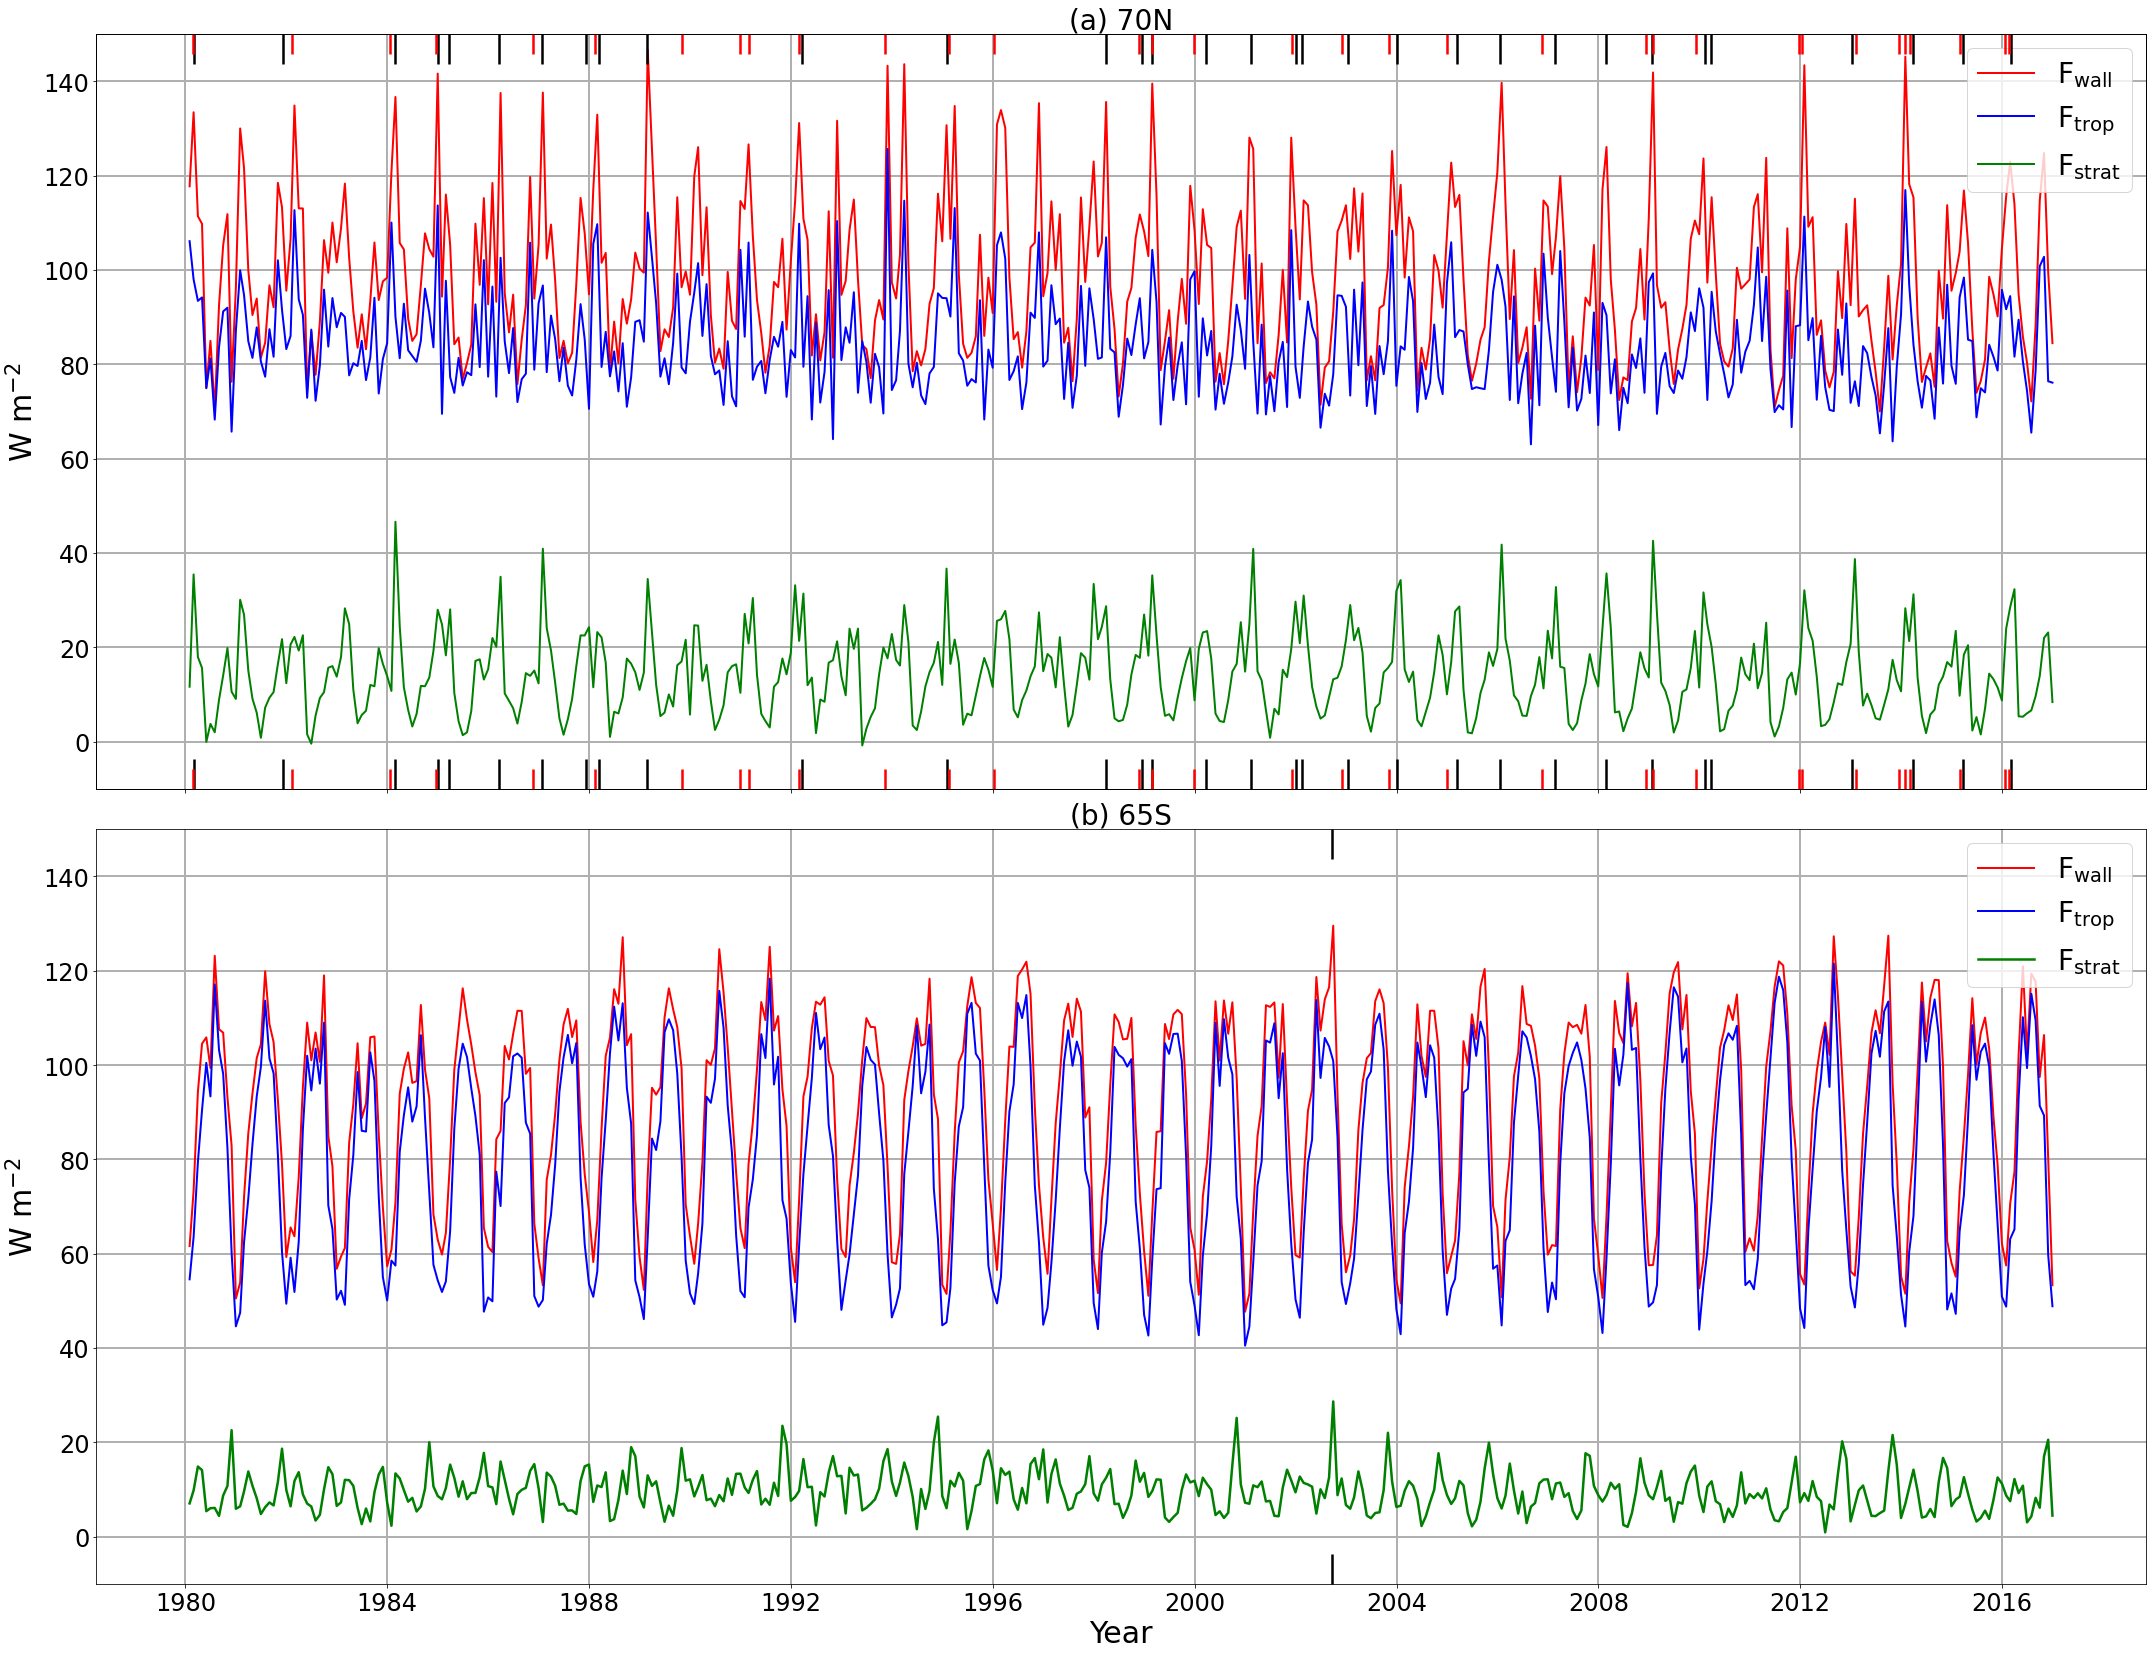

In [39]:
fig = plt.figure()
time=merra_ET2.time
fig,(ax, ax3) = plt.subplots(2, sharex=False,sharey='row',figsize=(30,24))
lev = np.arange(-5., 5., .1)
ax.plot(time,(integrate(monthly(MSE_H*c/a))),'r',lw=2,label='$\mathregular{F_{wall}}$')
ax.plot(time,(integrate_trop(monthly(MSE_H*c/a))),'b',lw=2,label='$\mathregular{F_{trop}}$')
ax.plot(time,(integrate_strat(monthly(MSE_H*c/a))),'g',lw=2,label='$\mathregular{F_{strat}}$')
ax.set_xticks(weak_events.values,minor=True)
ax.tick_params(which='minor', length=30,width=2.5, color='k',top=True,direction='in')
ax2 = ax.twiny()
ax2.plot(time,(integrate_strat(monthly(MSE_H*c/a))),c='g',lw=2,label='Strat',alpha=0.)
ax2.set_xticks(weak_events.values,minor=True)
ax2.tick_params(which='minor', width=2.5)
ax2.tick_params(which='minor', length=30, color='k',bottom=False,top=True,direction='in')
ax2.tick_params(which='major',top=False,labeltop=False)
ax1 = ax.twiny()
ax1.plot(time,(integrate_strat(monthly(MSE_H*c/a))),c='g',lw=2,label='Strat',alpha=0.)
ax1.set_xticks(time_nsf,minor=True)
ax1.tick_params(which='minor', width=2.5)
ax1.tick_params(which='minor', length=20, color='r',bottom=True,top=True,direction='in')
ax1.tick_params(which='major',top=False,labeltop=False)
ax.tick_params(axis='both',which='major', labelsize=24)
ax.axes.set_ybound(-10.,150.)
ax.set_xticklabels([])
ax.set_title('(a) 70N', fontsize = 28)
ax.set_ylabel('W m$^{-2}$', fontsize=30 )
ax.legend(loc='upper right',fontsize=28)
ax.grid(linewidth=2)
ax3.plot(time,-(integrate(MSE_H2*c2/a2)),'r',lw=2,label='$\mathregular{F_{wall}}$')
ax3.plot(time,-(integrate_trop(MSE_H2*c2/a2)),'b',lw=2,label='$\mathregular{F_{trop}}$')
ax3.plot(time,-(integrate_strat(MSE_H2*c2/a2)),'g',lw=2.5,label='$\mathregular{F_{strat}}$')
ax3.set_xticks(np.array(['2002-09-22'],dtype=np.datetime64),minor=True)
ax3.tick_params(which='minor', width=2.5)
ax3.tick_params(which='minor', length=30, color='k',top=True,direction='in')
ax3.tick_params(axis='both',which='major', labelsize=24)
ax3.axes.set_ybound(-10,150.)
ax3.set_title('(b) 65S', fontsize = 28)
ax3.set_ylabel('W m$^{-2}$', fontsize=30 )
ax3.set_xlabel('Year', fontsize=30 )
ax3.legend(loc='upper right',fontsize=28)
ax3.grid(linewidth=2)
fig.tight_layout()
fig.subplots_adjust(top=.94)
#plt.savefig('MSEseriesintegrJCLI2.pdf', bbox_inches='tight')

## Figure 5

<Figure size 432x288 with 0 Axes>

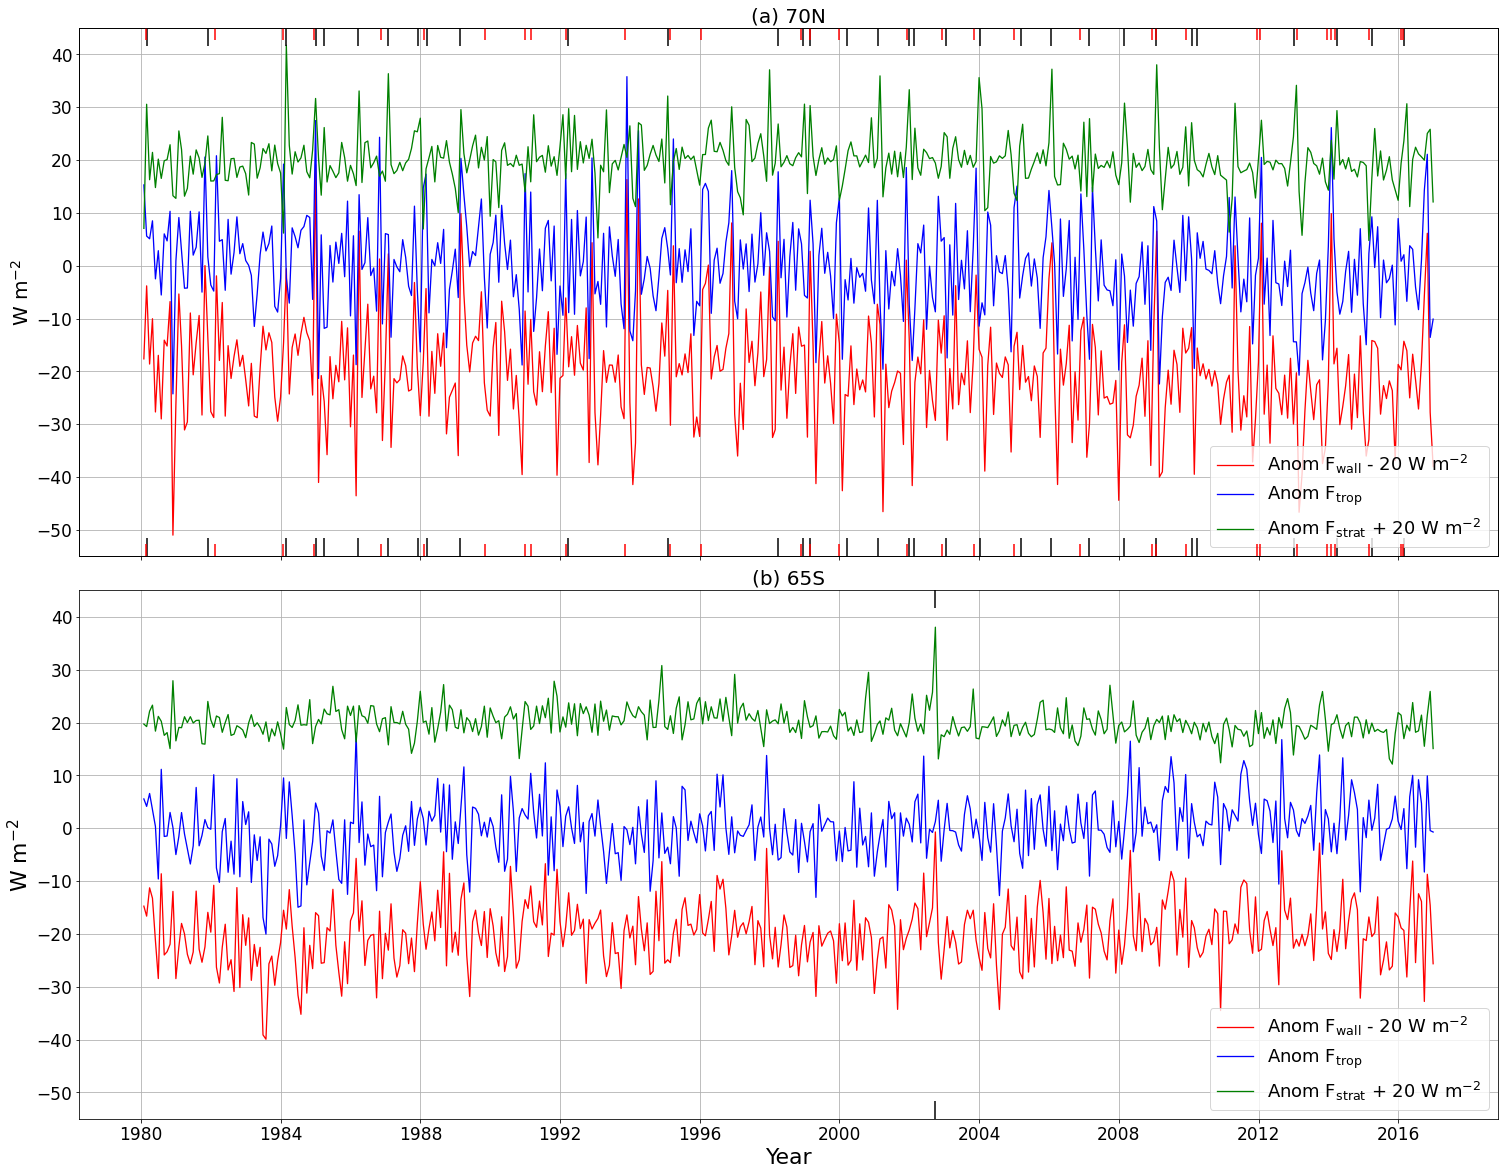

In [40]:
fig = plt.figure()
time=merra_ET2.time
fig,(ax, ax3) = plt.subplots(2, sharex=False,sharey='row',figsize=(21,17))
ax.plot(merra_ET2.time,(integrate(monthly(anom_H_trend*c/a)))-20,color='r',lw=1.3,label='Anom $\mathregular{F_{wall}}$ - 20 W m$^{-2}$')
ax.plot(merra_ET2.time,(integrate_trop(monthly(anom_H_trend*c/a))),lw=1.3,color='b',label='Anom $\mathregular{F_{trop}}$')
ax.plot(merra_ET2.time,(integrate_strat(monthly(anom_H_trend*c/a)))+20,lw=1.3,color='g',label='Anom $\mathregular{F_{strat}}$ + 20 W m$^{-2}$')
ax.set_xticks(weak_events.values,minor=True)
ax.tick_params(which='minor', length=18,width=1.5, color='k',top=True,direction='in')
ax4 = ax.twiny()
ax4.plot(time,(integrate_strat(monthly(anom_H)))+20,c='g',lw=2,label='Strat',alpha=0.)
ax4.set_xticks(weak_events.values,minor=True)
ax4.tick_params(which='minor', width=1.5)
ax4.tick_params(which='minor', length=18, color='k',bottom=False,top=True,direction='in')
ax4.tick_params(which='major',top=False,labeltop=False)
ax2 = ax.twiny()
ax2.plot(merra_ET2.time,(integrate_strat(monthly(anom_H)))+20,lw=2,color='g',alpha=0)
ax2.set_xticks(time_nsf,minor=True)
ax2.tick_params(which='minor', width=1.5)
ax2.tick_params(which='minor', length=12, color='r',bottom=True,top=True,direction='in')
ax2.tick_params(which='major',top=False,labeltop=False)
ax.set_ylabel('W m$^{-2}$', fontsize=20 )
ax.axes.set_ybound(-55,45)
ax.set_xticklabels([])
ax.set_yticks(np.arange(-50,50,10))
ax.set_title('(a) 70N', fontsize = 20)
ax.legend(loc='lower right',fontsize=18)
ax.grid()
ax3.plot(merra_ET2.time,-(integrate(anom_H2_trend*c2/a2))-20,color='r',lw=1.3,label='Anom $\mathregular{F_{wall}}$ - 20 W m$^{-2}$')
ax3.plot(merra_ET2.time,-(integrate_trop(anom_H2_trend*c2/a2)),lw=1.3,color='b',label='Anom $\mathregular{F_{trop}}$')
ax3.plot(merra_ET2.time,-(integrate_strat(anom_H2_trend*c2/a2))+20,lw=1.3,color='g',label='Anom $\mathregular{F_{strat}}$ + 20 W m$^{-2}$')
ax3.set_xticks(np.array(['2002-09-22'],dtype=np.datetime64),minor=True)
ax3.tick_params(which='minor', width=1.5)
ax3.tick_params(which='minor', length=18, color='k',bottom=True,top=True,direction='in')
ax3.set_ylabel('W m$^{-2}$', fontsize=22 )
ax3.set_xlabel('Year', fontsize=22)
ax3.axes.set_ybound(-55,45)
ax3.set_title('(b) 65S', fontsize = 20)
ax3.legend(loc='lower right',fontsize=18)
ax3.set_yticks(np.arange(-50,50,10))
ax.tick_params(axis='both',which='major', labelsize=17)
ax3.tick_params(axis='both',which='major', labelsize=17)
ax3.grid()

fig.tight_layout()
fig.subplots_adjust(top=.94)
#plt.savefig('MSEanomJCLI2.pdf', bbox_inches='tight')

### Correlations between F$_{\textrm{wall}}$, F$_{\textrm{trop}}$, and F$_{\textrm{strat}}$.

Similar correlations are found using daily and monthly anomalies, with the exception of the summer, especially when applying a low-pass filter to daily anomalies.

In [41]:
print('70N Fwall-Fstrat monthly correlation: {}, variance explained: {}'.format(pearson_correlation((ufunc(monthly(anom_H_trend),integrate)*c/a)
                                          ,(ufunc(monthly(anom_H_trend),integrate_strat)*c/a),'time').round(2).values,
(pearson_correlation((ufunc(monthly(anom_H_trend),integrate)*c/a)
                                          ,(ufunc(monthly(anom_H_trend),integrate_strat)*c/a),'time')**2).round(2).values))
print('70N Fwall-Fstrat daily correlation: {}, variance explained: {}'.format(pearson_correlation((ufunc((anom_H_trend),integrate)*c/a)
                                          ,(ufunc((anom_H_trend),integrate_strat)*c/a),'time').round(2).values,
(pearson_correlation((ufunc((anom_H_trend),integrate)*c/a)
                                          ,(ufunc((anom_H_trend),integrate_strat)*c/a),'time')**2).round(2).values))
print('70N Fwall-Fstrat daily correlation (low-pass filtered; 4-day cutoff timescale): {}, variance explained: {}'
      .format(pearson_correlation(low_filt(ufunc((anom_H_trend),integrate)*c/a,Wn=(1/4))
                                          ,low_filt(ufunc((anom_H_trend),integrate_strat)*c/a,Wn=(1/4)),'time').round(2),
(pearson_correlation(low_filt(ufunc((anom_H_trend),integrate)*c/a,Wn=(1/4))
                                          ,low_filt(ufunc((anom_H_trend),integrate_strat)*c/a,Wn=(1/4)),'time')**2).round(2)))
print('')
print('70N Summer Fwall-Fstrat monthly correlation: {}, variance explained: {}'.format(pearson_correlation((ufunc(monthly(anom_H_trend).sel(time=summer_nh_m),integrate)*c/a)
                                          ,(ufunc(monthly(anom_H_trend).sel(time=summer_nh_m),integrate_strat)*c/a),'time').round(2).values,
(pearson_correlation((ufunc(monthly(anom_H_trend).sel(time=summer_nh_m),integrate)*c/a)
                                          ,(ufunc(monthly(anom_H_trend).sel(time=summer_nh_m),integrate_strat)*c/a),'time')**2).round(2).values))
print('70N Summer Fwall-Fstrat daily correlation: {}, variance explained: {}'.format(pearson_correlation((ufunc((anom_H_trend).sel(time=summer_nh_d),integrate)*c/a)
                                          ,(ufunc((anom_H_trend).sel(time=summer_nh_d),integrate_strat)*c/a),'time').round(2).values,
(pearson_correlation((ufunc((anom_H_trend).sel(time=summer_nh_d),integrate)*c/a)
                                          ,(ufunc((anom_H_trend).sel(time=summer_nh_d),integrate_strat)*c/a),'time')**2).round(2).values))
print('70N Summer Fwall-Fstrat daily correlation (low-pass filtered; 4-day cutoff timescale): {}, variance explained: {}'
      .format(pearson_correlation(low_filt(ufunc((anom_H_trend).sel(time=summer_nh_d),integrate)*c/a,Wn=(1/4))
                                          ,low_filt(ufunc((anom_H_trend).sel(time=summer_nh_d),integrate_strat)*c/a,Wn=(1/4)),'time').round(2),
(pearson_correlation(low_filt(ufunc((anom_H_trend).sel(time=summer_nh_d),integrate)*c/a,Wn=(1/4))
                                          ,low_filt(ufunc((anom_H_trend).sel(time=summer_nh_d),integrate_strat)*c/a,Wn=(1/4)),'time')**2).round(2)))
print('')
print('70N Winter Fwall-Fstrat monthly correlation: {}, variance explained: {}'.format(pearson_correlation((ufunc(monthly(anom_H_trend).sel(time=winter_nh_m),integrate)*c/a)
                                          ,(ufunc(monthly(anom_H_trend).sel(time=winter_nh_m),integrate_strat)*c/a),'time').round(2).values,
(pearson_correlation((ufunc(monthly(anom_H_trend).sel(time=winter_nh_m),integrate)*c/a)
                                          ,(ufunc(monthly(anom_H_trend).sel(time=winter_nh_m),integrate_strat)*c/a),'time')**2).round(2).values))
print('70N Winter Fwall-Fstrat daily correlation: {}, variance explained: {}'.format(pearson_correlation((ufunc((anom_H_trend).sel(time=winter_nh_d),integrate)*c/a)
                                          ,(ufunc((anom_H_trend).sel(time=winter_nh_d),integrate_strat)*c/a),'time').round(2).values,
(pearson_correlation((ufunc((anom_H_trend).sel(time=winter_nh_d),integrate)*c/a)
                                          ,(ufunc((anom_H_trend).sel(time=winter_nh_d),integrate_strat)*c/a),'time')**2).round(2).values))
print('70N Winter Fwall-Fstrat daily correlation (low-pass filtered; 4-day cutoff timescale): {}, variance explained: {}'
      .format(pearson_correlation(low_filt(ufunc((anom_H_trend).sel(time=winter_nh_d),integrate)*c/a,Wn=(1/4))
                                          ,low_filt(ufunc((anom_H_trend).sel(time=winter_nh_d),integrate_strat)*c/a,Wn=(1/4)),'time').round(2),
(pearson_correlation(low_filt(ufunc((anom_H_trend).sel(time=winter_nh_d),integrate)*c/a,Wn=(1/4))
                                          ,low_filt(ufunc((anom_H_trend).sel(time=winter_nh_d),integrate_strat)*c/a,Wn=(1/4)),'time')**2).round(2)))
print('')
print('70N Ftrop-Fstrat monthly correlation: {}, variance explained: {}'.format(pearson_correlation((ufunc(monthly(anom_H_trend),integrate_trop)*c/a)
                                          ,(ufunc(monthly(anom_H_trend),integrate_strat)*c/a),'time').round(2).values,
(pearson_correlation((ufunc(monthly(anom_H_trend),integrate_trop)*c/a)
                                          ,(ufunc(monthly(anom_H_trend),integrate_strat)*c/a),'time')**2).round(2).values))
print('70N Ftrop-Fstrat daily correlation: {}, variance explained: {}'.format(pearson_correlation((ufunc((anom_H_trend),integrate_trop)*c/a)
                                          ,(ufunc((anom_H_trend),integrate_strat)*c/a),'time').round(2).values,
(pearson_correlation((ufunc((anom_H_trend),integrate_trop)*c/a)
                                          ,(ufunc((anom_H_trend),integrate_strat)*c/a),'time')**2).round(2).values))
print('70N Ftrop-Fstrat daily correlation (low-pass filtered; 4-day cutoff timescale): {}, variance explained: {}'
      .format(pearson_correlation(low_filt(ufunc((anom_H_trend),integrate_trop)*c/a,Wn=(1/4))
                                          ,low_filt(ufunc((anom_H_trend),integrate_strat)*c/a,Wn=(1/4)),'time').round(2),
(pearson_correlation(low_filt(ufunc((anom_H_trend),integrate_trop)*c/a,Wn=(1/4))
                                          ,low_filt(ufunc((anom_H_trend),integrate_strat)*c/a,Wn=(1/4)),'time')**2).round(2)))
print('')
print('70N Ftrop-Fstrat lagged monthly correlation (Ftrop leading by 1 month): {}'.format(pearson_correlation((ufunc(monthly(anom_H_trend).shift(time=1),integrate_trop)*c/a).dropna('time')
                                          ,(ufunc(monthly(anom_H_trend),integrate_strat)*c/a).sel(time=slice('1980-02','2017-01')),'time').round(2).values))
print('')
print('65S Fwall-Fstrat monthly correlation: {}, variance explained: {}'.format(pearson_correlation((ufunc((anom_H2_trend),integrate)*c/a)
                                          ,(ufunc((anom_H2_trend),integrate_strat)*c/a),'time').round(2).values,
(pearson_correlation((ufunc((anom_H2_trend),integrate)*c/a)
                                          ,(ufunc((anom_H2_trend),integrate_strat)*c/a),'time')**2).round(2).values))
print('65S Summer Fwall-Fstrat monthly correlation: {}, variance explained: {}'.format(pearson_correlation((ufunc((anom_H2_trend).sel(time=summer_sh),integrate)*c/a)
                                          ,(ufunc((anom_H2_trend).sel(time=summer_sh),integrate_strat)*c/a),'time').round(2).values,
(pearson_correlation((ufunc((anom_H2_trend).sel(time=summer_sh),integrate)*c/a)
                                          ,(ufunc((anom_H2_trend).sel(time=summer_sh),integrate_strat)*c/a),'time')**2).round(2).values))
print('65S Winter Fwall-Fstrat monthly correlation: {}, variance explained: {}'.format(pearson_correlation((ufunc((anom_H2_trend).sel(time=winter_sh),integrate)*c/a)
                                          ,(ufunc((anom_H2_trend).sel(time=winter_sh),integrate_strat)*c/a),'time').round(2).values,
(pearson_correlation((ufunc((anom_H2_trend).sel(time=winter_sh),integrate)*c/a)
                                          ,(ufunc((anom_H2_trend).sel(time=winter_sh),integrate_strat)*c/a),'time')**2).round(2).values))
print('')
print('65S Ftrop-Fstrat monthly correlation: {}, variance explained: {}'.format(pearson_correlation((ufunc((anom_H2_trend),integrate_trop)*c/a)
                                          ,(ufunc((anom_H2_trend),integrate_strat)*c/a),'time').round(2).values,
(pearson_correlation((ufunc((anom_H2_trend),integrate_trop)*c/a)
                                          ,(ufunc((anom_H2_trend),integrate_strat)*c/a),'time')**2).round(2).values))

70N Fwall-Fstrat monthly correlation: 0.48, variance explained: 0.23
70N Fwall-Fstrat daily correlation: 0.32, variance explained: 0.1
70N Fwall-Fstrat daily correlation (low-pass filtered; 4-day cutoff timescale): 0.38, variance explained: 0.14

70N Summer Fwall-Fstrat monthly correlation: 0.33, variance explained: 0.11
70N Summer Fwall-Fstrat daily correlation: -0.08, variance explained: 0.01
70N Summer Fwall-Fstrat daily correlation (low-pass filtered; 4-day cutoff timescale): -0.12, variance explained: 0.01

70N Winter Fwall-Fstrat monthly correlation: 0.52, variance explained: 0.27
70N Winter Fwall-Fstrat daily correlation: 0.39, variance explained: 0.16
70N Winter Fwall-Fstrat daily correlation (low-pass filtered; 4-day cutoff timescale): 0.45, variance explained: 0.2

70N Ftrop-Fstrat monthly correlation: 0.01, variance explained: 0.0
70N Ftrop-Fstrat daily correlation: -0.02, variance explained: 0.0
70N Ftrop-Fstrat daily correlation (low-pass filtered; 4-day cutoff timescale):

## Figure 6

In [42]:
#composites of energy flux convergence, surface and TOA fluxes, moist enthalphy tendency, and zonal wind during SSWs and DSFEs
ssw_ET_comp_total,ssw_ET_comp_strat,ssw_ET_comp_trop = [composite(ufunc(MSE_H*c/a,integ),weak_events) 
                                                        for integ in [integrate,integrate_strat,integrate_trop]]

nsf_ET_comp_total,nsf_ET_comp_strat,nsf_ET_comp_trop = [composite(ufunc(MSE_H*c/a,integ),time_nsf) 
                                                        for integ in [integrate,integrate_strat,integrate_trop]]

ssw_ET_comp_anom_total,ssw_ET_comp_anom_strat,ssw_ET_comp_anom_trop = [composite(ufunc(anom_H*c/a,integ),weak_events) 
                                                                       for integ in [integrate,integrate_strat,integrate_trop]]

nsf_ET_comp_anom_total,nsf_ET_comp_anom_strat,nsf_ET_comp_anom_trop = [composite(ufunc(anom_H*c/a,integ),time_nsf) 
                                                                       for integ in [integrate,integrate_strat,integrate_trop]]

ssw_D_comp_anom_strat,ssw_D_comp_anom_trop = [composite(ufunc(anom_D,integ),weak_events) 
                                                                       for integ in [integrate_strat,integrate_trop]]

nsf_D_comp_anom_strat,nsf_D_comp_anom_trop = [composite(ufunc(anom_D,integ),time_nsf) 
                                                                       for integ in [integrate_strat,integrate_trop]]

ssw_ET_comp = composite(MSE_H,weak_events)

nsf_ET_comp = composite(MSE_H,time_nsf)

ssw_u_comp = composite(u_10mb,weak_events)

ssw_OLR_comp_anom,ssw_DLR_comp_anom,ssw_ULR_comp_anom,ssw_DSW_comp_anom,ssw_comp_SHLH_anom = [composite((array),weak_events)
                                                        for array in [OLR_anom,DLR_anom,ULR_anom,DSW_anom,SHLH_anom]]

nsf_OLR_comp_anom,nsf_DLR_comp_anom,nsf_ULR_comp_anom,nsf_DSW_comp_anom,nsf_comp_SHLH_anom = [composite((array),time_nsf)
                                                        for array in [OLR_anom,DLR_anom,ULR_anom,DSW_anom,SHLH_anom]]

ssw_nsf_comp_anom = ssw_DLR_comp_anom+ssw_ULR_comp_anom+ssw_DSW_comp_anom+ssw_comp_SHLH_anom

nsf_comp_anom = nsf_DLR_comp_anom+nsf_ULR_comp_anom+nsf_DSW_comp_anom+nsf_comp_SHLH_anom

#climatological energy fluxes
total_climo = ufunc(MSE_H*c/a,integrate).sel(time=winter_nh_d).mean()

trop_climo = ufunc(MSE_H*c/a,integrate_trop).sel(time=winter_nh_d).mean()

strat_climo = ufunc(MSE_H*c/a,integrate_strat).sel(time=winter_nh_d).mean()

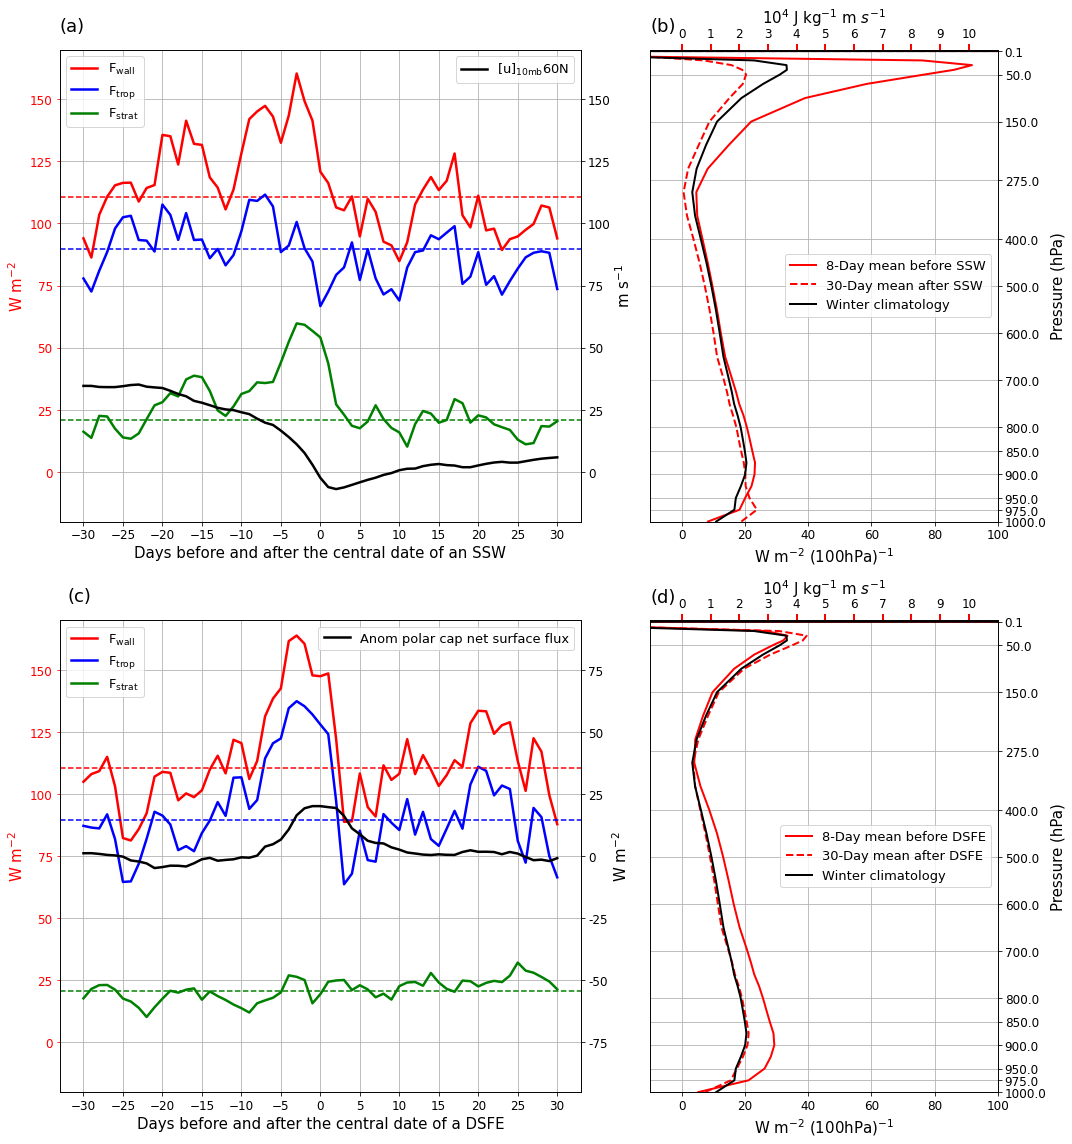

In [43]:
fig = plt.figure( figsize=(15,16) )
gs = plt.GridSpec(2, 2,
                       width_ratios=[1.5, 1],
                       )
ax = plt.subplot(gs[0])
time=np.arange(-30,31,1)
ax.axhline(total_climo,color='r',ls='--',lw=1.5,label='')
ax.axhline(trop_climo,color='b',ls='--',lw=1.5,label='')
ax.axhline(strat_climo,color='g',ls='--',lw=1.5,label='')
ax.plot(time,ssw_ET_comp_total,'r',ls='-',lw=2.5,label='$\mathregular{F_{wall}}$')
ax.plot(time,ssw_ET_comp_trop,'b',ls='-',lw=2.5,label='$\mathregular{F_{trop}}$')
ax.plot(time,ssw_ET_comp_strat,'g',ls='-',lw=2.5,label='$\mathregular{F_{strat}}$')

ax2 = ax.twinx()
ax2.plot(time,ssw_u_comp,'k',ls='-',lw=2.5,label = '$\mathregular{[u]_{10mb} 60N}$',ms=4)
ax3 = plt.subplot(gs[1])
levm=merra_ET.lev
ax3.plot(ssw_ET_comp.sel(day=slice(22,30)).mean('day')*h(),levm,ls='solid',lw=2,label='8-Day mean before SSW',color='r')
ax3.plot(ssw_ET_comp.sel(day=slice(31,61)).mean('day')*h(),levm,ls='dashed',lw=2,label='30-Day mean after SSW',color='r')
ax3.plot(MSE_H.sel(time=winter_nh_d).mean('time')*h(),levm,ls='solid',label='Winter climatology',lw=2,color='k')
ax4=ax3.twiny()
ax4.axes.set_xbound(-10,100)
ax4.set_xticks(np.array([0,1,2,3,4,5,6,7,8,9,10])*(h()*10**4))
ax4.set_xticklabels(np.array([0,1,2,3,4,5,6,7,8,9,10]),color='k')
ax4.tick_params(which='major',color='r', length=6,top=True,bottom=False,direction='out',width=2.0)
ax4.set_xlabel('$10^4$ J kg$^{-1}$ m $s^{-1}$', fontsize=15)

ax.set_ybound(-20,170)
ax2.set_ybound(-20,170)

ax.grid()
ax3.grid()
yticks = np.array([1000.,975,950,900,850,800,700,600, 500,400,275, 150, 50, .1])
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_yticks((yticks))
ax3.set_yticklabels(yticks)
ax3.set_xlabel('W m$^{-2}$ (100hPa)$^{-1}$', fontsize=15)
ax3.set_ylabel('Pressure (hPa)', fontsize=15 )
ax3.axes.invert_yaxis()
ax3.axes.set_ybound(1000.,-3.)
ax3.axes.set_xbound(-10,100)
ax3.legend(loc='center right',fontsize=13)
ax.tick_params(which='major',color='r',axis='y')
ax.set_yticks(np.array([0,25,50,75,100,125,150]))
ax2.set_yticks(np.array([0,25,50,75,100,125,150]))
ax2.set_yticklabels(np.array([0,25,50,75,100,125,150]),c='k')
ax.set_yticklabels(np.array([0,25,50,75,100,125,150]),c='r')
ax2.set_ylabel('m s$^{-1}$', fontsize=15,c='k')
ax.set_ylabel('W m$^{-2}$', fontsize=15,c='r')
ax.set_xlabel('Days before and after the central date of an SSW',fontsize=15)
ax.set_xticks(np.arange(-30,35,5))
ax2.legend(loc = 'upper right',fontsize=13)
ax.legend(loc = 'upper left',fontsize=13)
ax.text(-33,177.5,'(a)',fontsize=18)
ax3.text(-10,-42,'(b)',fontsize=18)

ax.tick_params(axis='both',which='major', labelsize=12)
ax2.tick_params(axis='both',which='major', labelsize=12)
ax3.tick_params(axis='both',which='major', labelsize=12)
ax4.tick_params(axis='both',which='major', labelsize=12)

ax5 = plt.subplot(gs[2])
time=np.arange(-30,31,1)
ax5.plot(time,nsf_ET_comp_total,'r',ls='-',lw=2.5,label='$\mathregular{F_{wall}}$')
ax5.plot(time,nsf_ET_comp_trop,'b',ls='-',lw=2.5,label='$\mathregular{F_{trop}}$')
ax5.plot(time,nsf_ET_comp_strat,'g',ls='-',lw=2.5,label='$\mathregular{F_{strat}}$')
ax5.axhline(total_climo,color='r',ls='--',lw=1.5,label='')
ax5.axhline(trop_climo,color='b',ls='--',lw=1.5,label='')
ax5.axhline(strat_climo,color='g',ls='--',lw=1.5,label='')

ax6 = ax5.twinx()
ax6.plot(time,nsf_comp_anom,'k',ls='-',lw=2.5,label = 'Anom polar cap net surface flux',ms=4)

ax7 = plt.subplot(gs[3])
levm=merra_ET.lev
ax7.plot(nsf_ET_comp.sel(day=slice(22,30)).mean('day')*h(),levm,ls='solid',lw=2,label='8-Day mean before DSFE',color='r')
ax7.plot(nsf_ET_comp.sel(day=slice(31,61)).mean('day')*h(),levm,ls='dashed',lw=2,label='30-Day mean after DSFE',color='r')
ax7.plot(MSE_H.sel(time=winter_nh_d).mean('time')*h(),levm,ls='solid',label='Winter climatology',lw=2,color='k')

ax8=ax7.twiny()
ax8.axes.set_xbound(-10,100)
ax8.set_xticks(np.array([0,1,2,3,4,5,6,7,8,9,10])*(h()*10**4))
ax8.set_xticklabels(np.array([0,1,2,3,4,5,6,7,8,9,10]),color='k')
ax8.tick_params(which='major',color='r', length=6,top=True,bottom=False,direction='out',width=2.0)
ax8.set_xlabel('$10^4$ J kg$^{-1}$ m $s^{-1}$', fontsize=15)

ax5.set_ybound(-20,170)
ax6.set_ybound(-95,95)

ax5.grid()
ax7.grid()
yticks = np.array([1000.,975,950,900,850,800,700,600, 500,400,275, 150, 50, .1])
ax7.yaxis.tick_right()
ax7.yaxis.set_label_position("right")
ax7.set_yticks((yticks))
ax7.set_yticklabels(yticks)
ax7.set_xlabel('W m$^{-2}$ (100hPa)$^{-1}$', fontsize=15)
ax7.set_ylabel('Pressure (hPa)', fontsize=15 )
ax7.axes.invert_yaxis()
ax7.axes.set_ybound(1000.,-3.)
ax7.axes.set_xbound(-10,100)
ax7.legend(loc='center right',fontsize=13)
ax5.tick_params(which='major',color='r',axis='y')
ax6.set_yticks(np.array([-75,-50,-25,0,25,50,75]))
ax6.set_yticklabels(np.array([-75,-50,-25,0,25,50,75]),c='k')
ax5.set_yticks(np.array([0,25,50,75,100,125,150]))
ax5.set_yticklabels(np.array([0,25,50,75,100,125,150]),c='r')
ax6.set_ylabel('W m$^{-2}$', fontsize=15,c='k')
ax5.set_ylabel('W m$^{-2}$', fontsize=15,c='r')
ax5.set_xlabel('Days before and after the central date of a DSFE',fontsize=15)
ax5.set_xticks(np.arange(-30,35,5))
ax6.legend(loc = 'upper right',fontsize=13)
ax5.legend(loc = 'upper left',fontsize=13)
ax5.text(-32,177.5,'(c)',fontsize=18)
ax7.text(-10,-42,'(d)',fontsize=18)
ax5.tick_params(axis='both',which='major', labelsize=12)
ax6.tick_params(axis='both',which='major', labelsize=12)
ax7.tick_params(axis='both',which='major', labelsize=12)
ax8.tick_params(axis='both',which='major', labelsize=12)
gs.tight_layout(fig)
#plt.savefig('compositesJCLI2.pdf', bbox_inches='tight')

The contribution from the anomalous LH flux convergence to the F$_{\textrm{trop}}$ anomaly in the 8-day mean prior to a DSFE is 6.6 W m$^{-2}$.

In [44]:
nsf_ET_comp_anom_trop_lh = composite(ufunc(detrend(anom_daily(LH_H))*c/a,integrate_trop),time_nsf)

In [45]:
nsf_ET_comp_anom_trop_lh.sel(day=slice(22,30)).mean()

<xarray.DataArray 'LH' ()>
array(6.57077491)

## Table 4

Only anomalies (in W m$^{-2}$) are shown here. For raw flux convergence values, use ```ssw_ET_comp_strat``` instead of ```ssw_ET_comp_anom_strat```, for example.

In [46]:
event_anomalies = pd.Index(['Fstrat: Anomaly Before SSW','Ftrop: Anomaly Before SSW','Fwall: Anomaly Before SSW',
                 'Fstrat: Anomaly Before DSFE','Ftrop: Anomaly Before DSFE','Fwall: Anomaly Before DSFE'],name='')
xr.concat([ssw_ET_comp_anom_strat.sel(day=slice(0,30)).mean(),ssw_ET_comp_anom_trop.sel(day=slice(0,30)).mean(),
 ssw_ET_comp_anom_total.sel(day=slice(0,30)).mean(),nsf_ET_comp_anom_strat.sel(day=slice(0,30)).mean()
           ,nsf_ET_comp_anom_trop.sel(day=slice(0,30)).mean(),nsf_ET_comp_anom_total.sel(day=slice(0,30)).mean()]
          ,event_anomalies).to_dataframe('').unstack()

  Fstrat: Anomaly Before SSW      8.823319
  Ftrop: Anomaly Before SSW       3.354367
  Fwall: Anomaly Before SSW      12.177686
  Fstrat: Anomaly Before DSFE    -1.803817
  Ftrop: Anomaly Before DSFE      7.625441
  Fwall: Anomaly Before DSFE      5.821624
dtype: float64

In [47]:
event_anomalies = pd.Index(['Fstrat: Anomaly After SSW','Ftrop: Anomaly After SSW','Fwall: Anomaly After SSW',
                 'Fstrat: Anomaly After DSFE','Ftrop: Anomaly After DSFE','Fwall: Anomaly After DSFE'],name='')
xr.concat([ssw_ET_comp_anom_strat.sel(day=slice(31,61)).mean(),ssw_ET_comp_anom_trop.sel(day=slice(31,61)).mean(),
 ssw_ET_comp_anom_total.sel(day=slice(31,61)).mean(),nsf_ET_comp_anom_strat.sel(day=slice(31,61)).mean()
           ,nsf_ET_comp_anom_trop.sel(day=slice(31,61)).mean(),nsf_ET_comp_anom_total.sel(day=slice(31,61)).mean()]
          ,event_anomalies).to_dataframe('').unstack()

  Fstrat: Anomaly After SSW    -0.693890
  Ftrop: Anomaly After SSW     -6.252723
  Fwall: Anomaly After SSW     -6.946614
  Fstrat: Anomaly After DSFE    2.342455
  Ftrop: Anomaly After DSFE    -1.136612
  Fwall: Anomaly After DSFE     1.205843
dtype: float64

## Figure 7

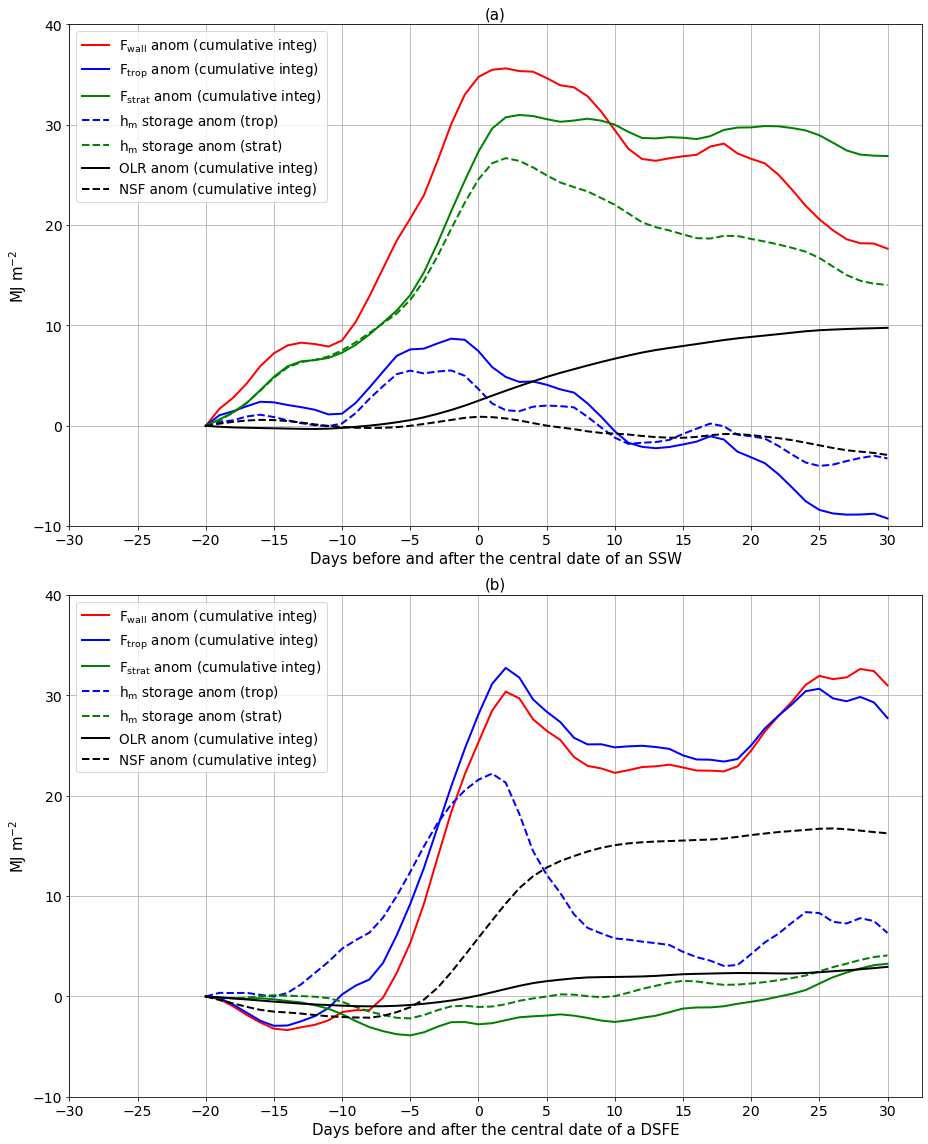

In [48]:
fig = plt.figure( figsize=(13,16) )
gs = plt.GridSpec(2, 1)
ax = plt.subplot(gs[0])
time=np.arange(-30,31,1)
ax.plot(time[10:61],integ.cumtrapz(ssw_ET_comp_anom_total[10:61],dx=sid,axis=0,initial=0)*10**-6,'r'
         ,ls='-',lw=2,label = '$\mathregular{F_{wall}}$ anom (cumulative integ)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(ssw_ET_comp_anom_trop[10:61],dx=sid,axis=0,initial=0)*10**-6,'b'
         ,ls='-',lw=2,label = '$\mathregular{F_{trop}}$ anom (cumulative integ)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(ssw_ET_comp_anom_strat[10:61],dx=sid,axis=0,initial=0)*10**-6,'g'
         ,ls='-',lw=2,label = '$\mathregular{F_{strat}}$ anom (cumulative integ)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(ssw_D_comp_anom_trop[10:61],dx=1,axis=0,initial=0)*10**-6,'b'
         ,ls='--',lw=2,label = '$\mathregular{h_{m}}$ storage anom (trop)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(ssw_D_comp_anom_strat[10:61],dx=1,axis=0,initial=0)*10**-6,'g'
         ,ls='--',lw=2,label = '$\mathregular{h_{m}}$ storage anom (strat)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(ssw_OLR_comp_anom[10:61],dx=sid,axis=0,initial=0)*10**-6,'k'
         ,ls='-',lw=2,label = 'OLR anom (cumulative integ)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(ssw_nsf_comp_anom[10:61],dx=sid,axis=0,initial=0)*10**-6,'k',ls='--'
         ,lw=2,label = 'NSF anom (cumulative integ)',ms=4)

ax.set_ylabel('MJ m$^{-2}$', fontsize=15,c='k')
ax.set_ybound(-10,40)
ax.grid()
ax.legend(fontsize=13.5)
ax.set_xticks(np.arange(-30,35,5))
ax.set_xlabel('Days before and after the central date of an SSW',fontsize=15)
ax.set_title('(a)', fontsize = 15)
ax.tick_params(axis='both',which='major', labelsize=14)

ax = plt.subplot(gs[1])
time=np.arange(-30,31,1)
ax.plot(time[10:61],integ.cumtrapz(nsf_ET_comp_anom_total[10:61],dx=sid,axis=0,initial=0)*10**-6,'r'
         ,ls='-',lw=2,label = '$\mathregular{F_{wall}}$ anom (cumulative integ)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(nsf_ET_comp_anom_trop[10:61],dx=sid,axis=0,initial=0)*10**-6,'b'
         ,ls='-',lw=2,label = '$\mathregular{F_{trop}}$ anom (cumulative integ)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(nsf_ET_comp_anom_strat[10:61],dx=sid,axis=0,initial=0)*10**-6,'g'
         ,ls='-',lw=2,label = '$\mathregular{F_{strat}}$ anom (cumulative integ)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(nsf_D_comp_anom_trop[10:61],dx=1,axis=0,initial=0)*10**-6,'b'
         ,ls='--',lw=2,label = '$\mathregular{h_{m}}$ storage anom (trop)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(nsf_D_comp_anom_strat[10:61],dx=1,axis=0,initial=0)*10**-6,'g'
         ,ls='--',lw=2,label = '$\mathregular{h_{m}}$ storage anom (strat)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(nsf_OLR_comp_anom[10:61],dx=sid,axis=0,initial=0)*10**-6,'k'
         ,ls='-',lw=2,label = 'OLR anom (cumulative integ)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(nsf_comp_anom[10:61],dx=sid,axis=0,initial=0)*10**-6,'k',ls='--'
         ,lw=2,label = 'NSF anom (cumulative integ)',ms=4)

ax.set_ylabel('MJ m$^{-2}$', fontsize=15,c='k')
ax.set_ybound(-10,40)
ax.grid()
ax.legend(fontsize=13.5)
ax.set_xticks(np.arange(-30,35,5))
ax.set_xlabel('Days before and after the central date of a DSFE',fontsize=15)
ax.set_title('(b)', fontsize = 15)
ax.tick_params(axis='both',which='major', labelsize=14)
gs.tight_layout(fig)
#plt.savefig('intcompositesJCLI2.pdf', bbox_inches='tight')

**See manuscript for Figure 8 (shematic; https://doi.org/10.1175/jcli-d-20-0722.1)**

## Figure 9

In [49]:
#correlations between Fwall and Ftrop and lower-tropospheric (1000-900 hPa) moist enthalpy tendencies for different rolling means
#in the annual winter and summer
COR_TOT = np.array([pearson_correlation(ufunc((anom_H_trend),integrate).rolling(time=x,center=True,min_periods=1).mean().dropna('time'),
                   ufunc(anom_D_trend/Cp,curly_bracket_tropl).rolling(time=x,center=True,min_periods=1).mean().dropna('time'),
                   'time').values for x in range(1,31)])

COR_TOT_w = np.array([pearson_correlation(ufunc((anom_H_trend),integrate).rolling(time=x,center=True,min_periods=1).mean().sel(time=winter_nh_d).dropna('time'),
                   ufunc(anom_D_trend/Cp,curly_bracket_tropl).rolling(time=x,center=True,min_periods=1).mean().sel(time=winter_nh_d).dropna('time'),
                   'time').values for x in range(1,31)])

COR_TOT_s = np.array([pearson_correlation(ufunc((anom_H_trend),integrate).rolling(time=x,center=True,min_periods=1).mean().sel(time=summer_nh_d).dropna('time'),
                   ufunc(anom_D_trend/Cp,curly_bracket_tropl).rolling(time=x,center=True,min_periods=1).mean().sel(time=summer_nh_d).dropna('time'),
                   'time').values for x in range(1,31)])

COR_TROP = np.array([pearson_correlation(ufunc((anom_H_trend),integrate_trop).rolling(time=x,center=True,min_periods=1).mean().dropna('time'),
                   ufunc(anom_D_trend/Cp,curly_bracket_tropl).rolling(time=x,center=True,min_periods=1).mean().dropna('time'),
                   'time').values for x in range(1,31)])

COR_TROP_w = np.array([pearson_correlation(ufunc((anom_H_trend),integrate_trop).rolling(time=x,center=True,min_periods=1).mean().sel(time=winter_nh_d).dropna('time'),
                   ufunc(anom_D_trend/Cp,curly_bracket_tropl).rolling(time=x,center=True,min_periods=1).mean().sel(time=winter_nh_d).dropna('time'),
                   'time').values for x in range(1,31)])

COR_TROP_s = np.array([pearson_correlation(ufunc((anom_H_trend),integrate_trop).rolling(time=x,center=True,min_periods=1).mean().sel(time=summer_nh_d).dropna('time'),
                   ufunc(anom_D_trend/Cp,curly_bracket_tropl).rolling(time=x,center=True,min_periods=1).mean().sel(time=summer_nh_d).dropna('time'),
                   'time').values for x in range(1,31)])

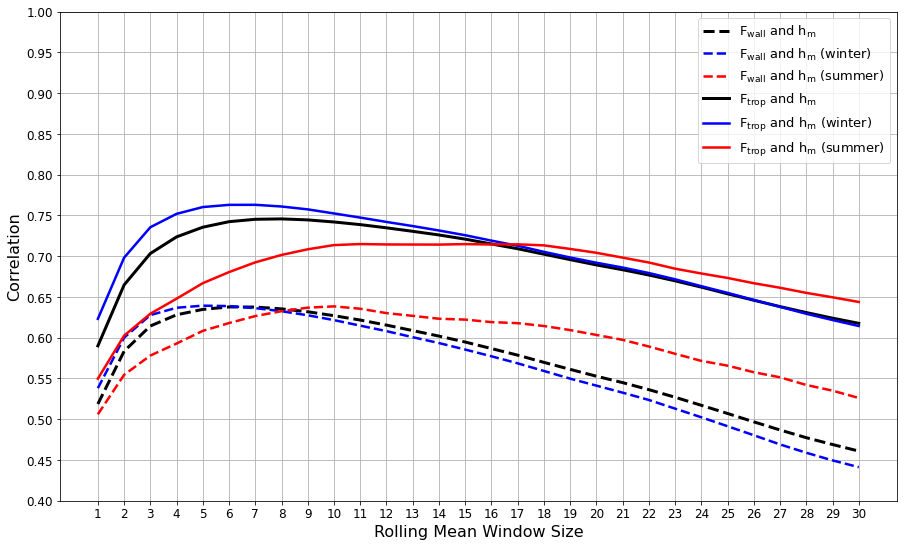

In [50]:
fig = plt.figure( figsize=(15,9) )
ax = fig.add_subplot(111)
ax.plot(COR_TOT,'k--',lw=3,label='$\mathregular{F_{wall}}$ and $\mathregular{h{_m}}$')
ax.plot(COR_TOT_w,'b--',lw=2.5,label='$\mathregular{F_{wall}}$ and $\mathregular{h{_m}}$ (winter)')
ax.plot(COR_TOT_s,'r',ls='--',lw=2.5,label='$\mathregular{F_{wall}}$ and $\mathregular{h{_m}}$ (summer)')
ax.plot(COR_TROP,'k',lw=3,label='$\mathregular{F_{trop}}$ and $\mathregular{h{_m}}$')
ax.plot(COR_TROP_w,'b',lw=2.5,label='$\mathregular{F_{trop}}$ and $\mathregular{h{_m}}$ (winter)')
ax.plot(COR_TROP_s,'r',lw=2.5,label='$\mathregular{F_{trop}}$ and $\mathregular{h{_m}}$ (summer)')

ax.set_xticks(np.arange(0,30,1))
ax.set_xticklabels(np.arange(1,31,1))
ax.set_ybound(.4,1)
ax.set_yticks(np.arange(.4,1.05,.05))
ax.grid()
ax.set_ylabel('Correlation', fontsize=16 )
ax.set_xlabel('Rolling Mean Window Size', fontsize=16 )
ax.legend(fontsize=13)

ax.tick_params(axis='both',which='major', labelsize=12)

#plt.savefig('correlationJCLI2.pdf', bbox_inches='tight')

**Similar results are found when using a low-pass filter instead of rolling means**

In [51]:
COR_TOT2 = xr.DataArray([(pearson_correlation(low_filt(ufunc(anom_H_trend,integrate)*c/a,Wn=(1/x))
                                          ,low_filt(ufunc(anom_D_trend/Cp,curly_bracket_tropl),Wn=(1/x)),'time'))
 for x in range(2,31)],coords=[np.arange(2,31,1)],dims=['time'])
COR_TOT2_D1 = pearson_correlation(ufunc(anom_H_trend,integrate)*c/a
                                          ,ufunc(anom_D_trend/Cp,curly_bracket_tropl),'time').assign_coords(time=2)
COR_TOT2=xr.concat([COR_TOT2_D1 ,COR_TOT2],'time')

COR_TOT_w2 = xr.DataArray([(pearson_correlation(low_filt(ufunc(anom_H_trend.sel(time=winter_nh_d),integrate)*c/a,Wn=(1/x))
                                          ,low_filt(ufunc(anom_D_trend.sel(time=winter_nh_d)/Cp,curly_bracket_tropl),Wn=(1/x)),'time'))
 for x in range(2,31)],coords=[np.arange(2,31,1)],dims=['time'])
COR_TOT_w2_D1 = pearson_correlation(ufunc(anom_H_trend.sel(time=winter_nh_d),integrate)*c/a
                                          ,ufunc(anom_D_trend.sel(time=winter_nh_d)/Cp,curly_bracket_tropl),'time').assign_coords(time=2)
COR_TOT_w2=xr.concat([COR_TOT_w2_D1 ,COR_TOT_w2],'time')

COR_TOT_s2 = xr.DataArray([(pearson_correlation(low_filt(ufunc(anom_H_trend.sel(time=summer_nh_d),integrate)*c/a,Wn=(1/x))
                                          ,low_filt(ufunc(anom_D_trend.sel(time=summer_nh_d)/Cp,curly_bracket_tropl),Wn=(1/x)),'time'))
 for x in range(2,31)],coords=[np.arange(2,31,1)],dims=['time'])
COR_TOT_s2_D1 = pearson_correlation(ufunc(anom_H_trend.sel(time=summer_nh_d),integrate)*c/a
                                          ,ufunc(anom_D_trend.sel(time=summer_nh_d)/Cp,curly_bracket_tropl),'time').assign_coords(time=2)
COR_TOT_s2=xr.concat([COR_TOT_s2_D1 ,COR_TOT_s2],'time')

COR_TROP2 = xr.DataArray([(pearson_correlation(low_filt(ufunc(anom_H_trend,integrate_trop)*c/a,Wn=(1/x))
                                          ,low_filt(ufunc(anom_D_trend/Cp,curly_bracket_tropl),Wn=(1/x)),'time'))
 for x in range(2,31)],coords=[np.arange(2,31,1)],dims=['time'])
COR_TROP2_D1 = pearson_correlation(ufunc(anom_H_trend,integrate_trop)*c/a
                                          ,ufunc(anom_D_trend/Cp,curly_bracket_tropl),'time').assign_coords(time=2)
COR_TROP2=xr.concat([COR_TROP2_D1 ,COR_TROP2],'time')

COR_TROP_w2 = xr.DataArray([(pearson_correlation(low_filt(ufunc(anom_H_trend.sel(time=winter_nh_d),integrate_trop)*c/a,Wn=(1/x))
                                          ,low_filt(ufunc(anom_D_trend.sel(time=winter_nh_d)/Cp,curly_bracket_tropl),Wn=(1/x)),'time'))
 for x in range(2,31)],coords=[np.arange(2,31,1)],dims=['time'])
COR_TROP_w2_D1 = pearson_correlation(ufunc(anom_H_trend.sel(time=winter_nh_d),integrate_trop)*c/a
                                          ,ufunc(anom_D_trend.sel(time=winter_nh_d)/Cp,curly_bracket_tropl),'time').assign_coords(time=2)
COR_TROP_w2=xr.concat([COR_TROP_w2_D1 ,COR_TROP_w2],'time')

COR_TROP_s2 = xr.DataArray([(pearson_correlation(low_filt(ufunc(anom_H_trend.sel(time=summer_nh_d),integrate_trop)*c/a,Wn=(1/x))
                                          ,low_filt(ufunc(anom_D_trend.sel(time=summer_nh_d)/Cp,curly_bracket_tropl),Wn=(1/x)),'time'))
 for x in range(2,31)],coords=[np.arange(2,31,1)],dims=['time'])
COR_TROP_s2_D1 = pearson_correlation(ufunc(anom_H_trend.sel(time=summer_nh_d),integrate_trop)*c/a
                                          ,ufunc(anom_D_trend.sel(time=summer_nh_d)/Cp,curly_bracket_tropl),'time').assign_coords(time=2)
COR_TROP_s2=xr.concat([COR_TROP_s2_D1 ,COR_TROP_s2],'time')

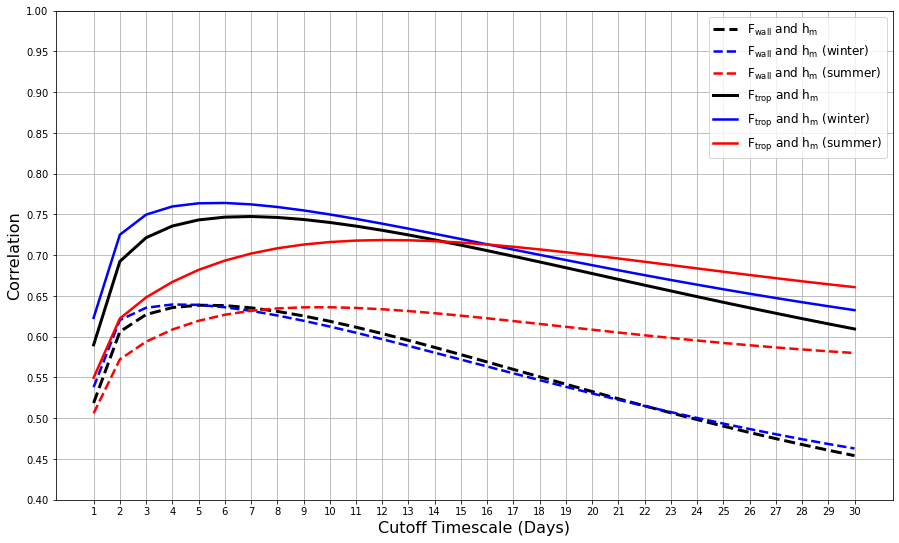

In [52]:
#unpublished figure for comparison with figure 9
fig = plt.figure( figsize=(15,9) )
ax = fig.add_subplot(111)
ax.plot(COR_TOT2,'k--',lw=3,label='$\mathregular{F_{wall}}$ and $\mathregular{h{_m}}$')
ax.plot(COR_TOT_w2,'b--',lw=2.5,label='$\mathregular{F_{wall}}$ and $\mathregular{h{_m}}$ (winter)')
ax.plot(COR_TOT_s2,'r',ls='--',lw=2.5,label='$\mathregular{F_{wall}}$ and $\mathregular{h{_m}}$ (summer)')
ax.plot(COR_TROP2,'k',lw=3,label='$\mathregular{F_{trop}}$ and $\mathregular{h{_m}}$')
ax.plot(COR_TROP_w2,'b',lw=2.5,label='$\mathregular{F_{trop}}$ and $\mathregular{h{_m}}$ (winter)')
ax.plot(COR_TROP_s2,'r',lw=2.5,label='$\mathregular{F_{trop}}$ and $\mathregular{h{_m}}$ (summer)')

ax.set_xticks(np.arange(0,30,1))
ax.set_xticklabels(np.arange(1,31,1))
ax.set_ybound(.4,1)
ax.set_yticks(np.arange(.4,1.05,.05))
ax.grid()
ax.set_ylabel('Correlation', fontsize=16 )
ax.set_xlabel('Cutoff Timescale (Days)', fontsize=16 )
ax.legend(fontsize=12)

## Figure A1

In [53]:
v_filt = ufunc2(merra_V.V,low_filt)

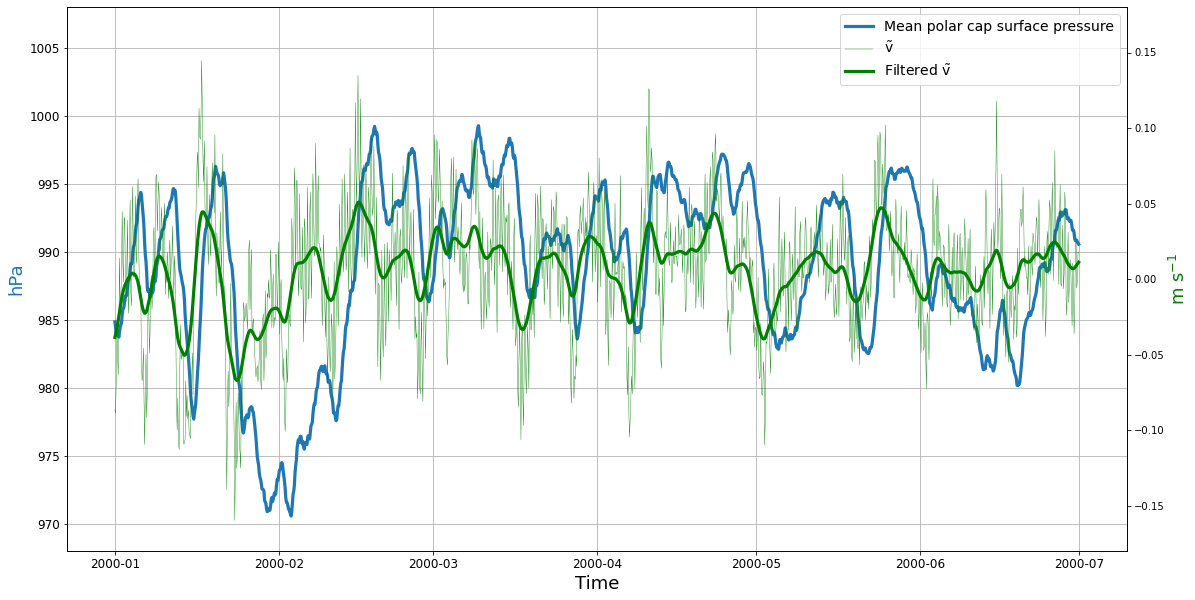

In [54]:
import pandas as pd
fig = plt.figure( figsize=(19,10) )
ax = fig.add_subplot(111)
ln1 = ax.plot(merra_PS.PS.sel(time=slice('2000-01-01','2000-6-30')).time,merra_PS.PS.sel(time=slice('2000-01-01','2000-6-30'))/100.,'tab:blue',lw='3.2',label='Mean polar cap surface pressure')
ax.set_xticks(np.arange('2000-01-01','2000-08-01', dtype='datetime64[1M]'))
ax.set_xticklabels(np.arange('2000-01-01','2000-08-01', dtype='datetime64[1M]'))
ax2 = ax.twinx()
ln2 = ax2.plot(merra_V.V.sel(time=slice('2000-01-01','2000-6-30')).time,merra_V.V.sel(time=slice('2000-01-01','2000-6-30')),'g',lw='.39',label='$\mathregular{\~v}$')
ln3 = ax2.plot(merra_V.V.sel(time=slice('2000-01-01','2000-06-30')).time,v_filt.sel(time=slice('2000-01-01','2000-06-30')),'g',lw='3.2',label='Filtered $\mathregular{\~v}$')
ax2.axes.set_ybound(-.18,.18)
ax.axes.set_ybound(968,1008)
ln = ln1+ln2+ln3
labs = [l.get_label() for l in ln]
ax.legend(ln, labs, loc='upper right',fontsize=14)
label1 = ax.set_ylabel('hPa', fontsize=18)
label2 = ax2.set_ylabel('m s$^{-1}$', fontsize=18 )
label1.set_color('tab:blue')
label2.set_color('g')
ax.set_xlabel('Time',fontsize=18)
ax.tick_params(axis='both',which='major', labelsize=12)
ax.grid()
#plt.savefig('correctionJCLI2.pdf')

Correlation between the low-pass filtered merididional wind and polar cap&ndash;averaged surface pressure

In [55]:
pearson_correlation(v_filt.sel(time=slice('2000','2000-12-31')).shift(time=8).dropna('time')
                    ,merra_PS.PS.sel(time=slice('2000-01-02','2000-12-31')),'time').values

array(0.65267313)

## Figure B1

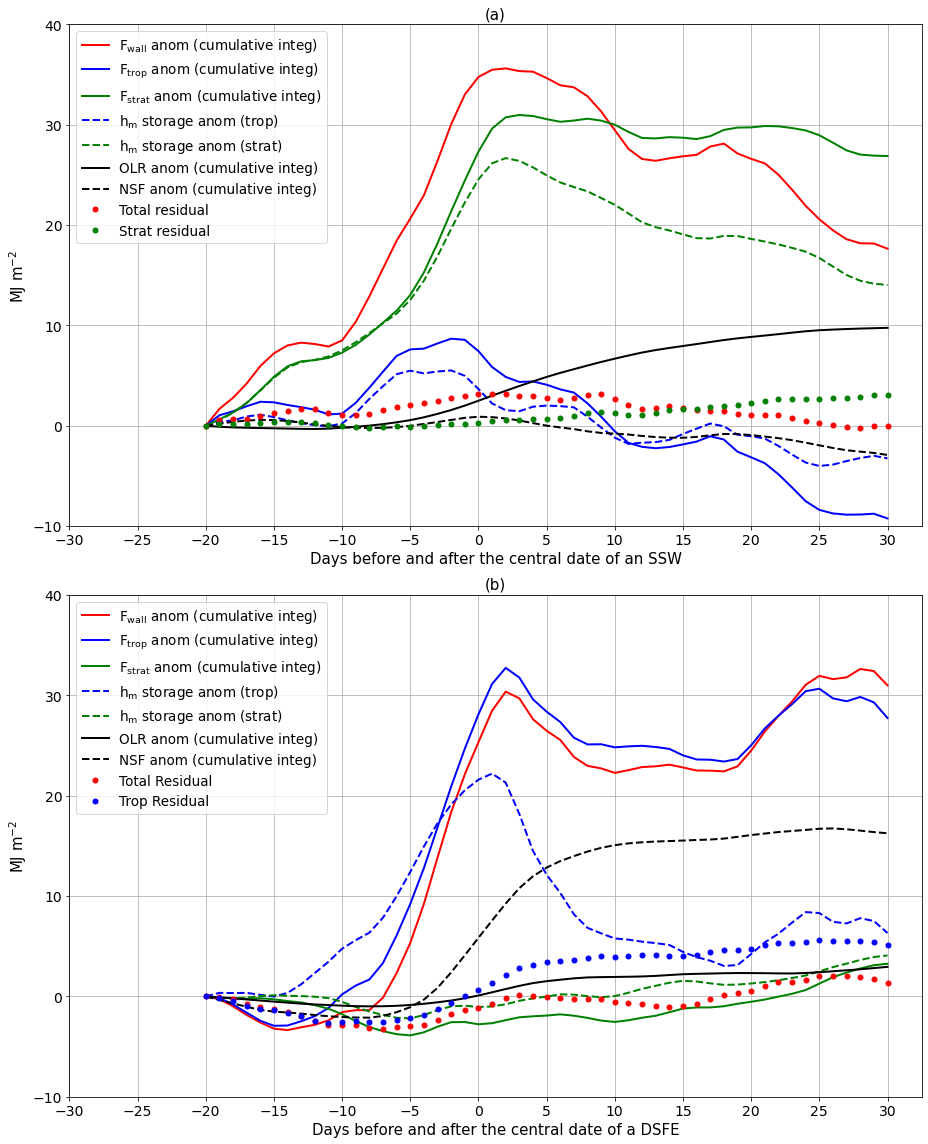

In [56]:
fig = plt.figure( figsize=(13,16) )
gs = plt.GridSpec(2, 1)
ax = plt.subplot(gs[0])
time=np.arange(-30,31,1)
ax.plot(time[10:61],integ.cumtrapz(ssw_ET_comp_anom_total[10:61],dx=sid,axis=0,initial=0)*10**-6,'r'
         ,ls='-',lw=2,label = '$\mathregular{F_{wall}}$ anom (cumulative integ)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(ssw_ET_comp_anom_trop[10:61],dx=sid,axis=0,initial=0)*10**-6,'b'
         ,ls='-',lw=2,label = '$\mathregular{F_{trop}}$ anom (cumulative integ)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(ssw_ET_comp_anom_strat[10:61],dx=sid,axis=0,initial=0)*10**-6,'g'
         ,ls='-',lw=2,label = '$\mathregular{F_{strat}}$ anom (cumulative integ)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(ssw_D_comp_anom_trop[10:61],dx=1,axis=0,initial=0)*10**-6,'b'
         ,ls='--',lw=2,label = '$\mathregular{h_{m}}$ storage anom (trop)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(ssw_D_comp_anom_strat[10:61],dx=1,axis=0,initial=0)*10**-6,'g'
         ,ls='--',lw=2,label = '$\mathregular{h_{m}}$ storage anom (strat)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(ssw_OLR_comp_anom[10:61],dx=sid,axis=0,initial=0)*10**-6,'k'
         ,ls='-',lw=2,label = 'OLR anom (cumulative integ)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(ssw_nsf_comp_anom[10:61],dx=sid,axis=0,initial=0)*10**-6,'k',ls='--'
         ,lw=2,label = 'NSF anom (cumulative integ)',ms=4)

ax.plot(time[10:61],((integ.cumtrapz(ssw_ET_comp_anom_total[10:61],dx=sid,axis=0,initial=0)*10**-6)-
                     (integ.cumtrapz(ssw_D_comp_anom_trop[10:61],dx=1,axis=0,initial=0)*10**-6)-
                     (integ.cumtrapz(ssw_D_comp_anom_strat[10:61],dx=1,axis=0,initial=0)*10**-6)-
                     (integ.cumtrapz(ssw_OLR_comp_anom[10:61],dx=sid,axis=0,initial=0)*10**-6)-
                     (integ.cumtrapz(ssw_nsf_comp_anom[10:61],dx=sid,axis=0,initial=0)*10**-6)),'r',ls=''
         ,lw=3,label = 'Total residual',ms=5,marker='o')

ax.plot(time[10:61],((integ.cumtrapz(ssw_ET_comp_anom_strat[10:61],dx=sid,axis=0,initial=0)*10**-6)-
                     ((integ.cumtrapz(ssw_D_comp_anom_strat[10:61],dx=1,axis=0,initial=0)*10**-6)+
                     (integ.cumtrapz(ssw_OLR_comp_anom[10:61],dx=sid,axis=0,initial=0)*10**-6))),'g',ls=''
         ,lw=3,label = 'Strat residual',ms=5,marker='o')

ax.set_ylabel('MJ m$^{-2}$', fontsize=15,c='k')
ax.set_ybound(-10,40)
ax.grid()
ax.legend(fontsize=13.5)
ax.set_xticks(np.arange(-30,35,5))
ax.set_xlabel('Days before and after the central date of an SSW',fontsize=15)
ax.set_title('(a)', fontsize = 15)
ax.tick_params(axis='both',which='major', labelsize=14)

ax = plt.subplot(gs[1])
time=np.arange(-30,31,1)
ax.plot(time[10:61],integ.cumtrapz(nsf_ET_comp_anom_total[10:61],dx=sid,axis=0,initial=0)*10**-6,'r'
         ,ls='-',lw=2,label = '$\mathregular{F_{wall}}$ anom (cumulative integ)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(nsf_ET_comp_anom_trop[10:61],dx=sid,axis=0,initial=0)*10**-6,'b'
         ,ls='-',lw=2,label = '$\mathregular{F_{trop}}$ anom (cumulative integ)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(nsf_ET_comp_anom_strat[10:61],dx=sid,axis=0,initial=0)*10**-6,'g'
         ,ls='-',lw=2,label = '$\mathregular{F_{strat}}$ anom (cumulative integ)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(nsf_D_comp_anom_trop[10:61],dx=1,axis=0,initial=0)*10**-6,'b'
         ,ls='--',lw=2,label = '$\mathregular{h_{m}}$ storage anom (trop)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(nsf_D_comp_anom_strat[10:61],dx=1,axis=0,initial=0)*10**-6,'g'
         ,ls='--',lw=2,label = '$\mathregular{h_{m}}$ storage anom (strat)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(nsf_OLR_comp_anom[10:61],dx=sid,axis=0,initial=0)*10**-6,'k'
         ,ls='-',lw=2,label = 'OLR anom (cumulative integ)',ms=4)
ax.plot(time[10:61],integ.cumtrapz(nsf_comp_anom[10:61],dx=sid,axis=0,initial=0)*10**-6,'k',ls='--'
         ,lw=2,label = 'NSF anom (cumulative integ)',ms=4)

ax.plot(time[10:61],((integ.cumtrapz(nsf_ET_comp_anom_total[10:61],dx=sid,axis=0,initial=0)*10**-6)-
                     (integ.cumtrapz(nsf_D_comp_anom_trop[10:61],dx=1,axis=0,initial=0)*10**-6)-
                     (integ.cumtrapz(nsf_D_comp_anom_strat[10:61],dx=1,axis=0,initial=0)*10**-6)-
                     (integ.cumtrapz(nsf_OLR_comp_anom[10:61],dx=sid,axis=0,initial=0)*10**-6)-
                     (integ.cumtrapz(nsf_comp_anom[10:61],dx=sid,axis=0,initial=0)*10**-6)),'r',ls=''
         ,lw=3,label = 'Total Residual',ms=5,marker='o')

ax.plot(time[10:61],((integ.cumtrapz(nsf_ET_comp_anom_trop[10:61],dx=sid,axis=0,initial=0)*10**-6)-
                     ((integ.cumtrapz(nsf_D_comp_anom_trop[10:61],dx=1,axis=0,initial=0)*10**-6)+
                     (integ.cumtrapz(nsf_comp_anom[10:61],dx=sid,axis=0,initial=0)*10**-6))),'b',ls=''
         ,lw=3,label = 'Trop Residual',ms=5,marker='o')

ax.set_ylabel('MJ m$^{-2}$', fontsize=15,c='k')
ax.set_ybound(-10,40)
ax.grid()
ax.legend(fontsize=13.5)
ax.set_xticks(np.arange(-30,35,5))
ax.set_xlabel('Days before and after the central date of a DSFE',fontsize=15)
ax.set_title('(b)', fontsize = 15)
ax.tick_params(axis='both',which='major', labelsize=14)
gs.tight_layout(fig)
#plt.savefig('residJCLI2.pdf', bbox_inches='tight')